# Machine Learning project - Flavia Leotta 45866A
## Bioinformatics for Computational Genomics - 2024/2025
Time required to run the entire notebook: around 45 minutes.

## Goals
The goals of this project are to use Machine Learning concepts and Python libraries, to tackle three different tasks:
1. Build a regression model that can accurately predict missing values for "totcst";
2. Build a classification model that, at the moment of admission to the study, can predict if a patient has more or less chances of dying;
3. Perform a clustering analysis to understand whether we can identify several degrees of severity in the patients’ conditions based on the variable "sfdm2".

After cleaning of data, each task is undertaken in the order presented.

### Libraries 
Necessary libraries. Please make sure you already have them installed in your system (by running:

$\texttt{pip install pandas numpy seaborn matplotlib scikit-learn statsmodels ucimlrepo umap-learn}$

on Terminal).

In [1]:
# Base libraries
import pandas as pd
import numpy as np
import random
import math

# Dataset library
from ucimlrepo import fetch_ucirepo 

# Libraries for visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib.gridspec as gridspec
from sklearn.inspection import PartialDependenceDisplay

# Others
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.pipeline import Pipeline

# Libraries for Regression and Classification
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

# Libraries for evalution
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, accuracy_score, f1_score, roc_auc_score, silhouette_score, adjusted_rand_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import statsmodels.api as sm

# Libraries for clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

# Libraries for dimensionality reduction
from sklearn.decomposition import PCA
import umap.umap_ as umap


C:\Users\flavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


I personalise graph visualization: please run this code for the personalised palette used in almost all graphs.

In [2]:
# Fonts
plt.rcParams["font.family"] = "monospace"

# Custom color palette for graphs
custom_colors = ['#264653', '#2a9d8f', '#e9c46a', '#f4a261', '#e76f51']

# Categorical
custom_cmap_categorical = ListedColormap(custom_colors)

# Custom color palette specifically for the heatmap we're going to see later
custom_colors2 = ['#264653', '#2a9d8f', '#dfdfdf', '#f4a261', '#e76f51']

# Gradient
custom_cmap_gradient = LinearSegmentedColormap.from_list("custom_gradient", custom_colors2)


# 0. Dataset

The dataset we're going to work on can be a little complicated to navigate. I first import the dataset in this notebook. Before running this, I downloaded it on my computer throught the terminal by using _pip install ucimlrepo_.

In [3]:
# I fetch the specific dataset that has id 880
support2 = fetch_ucirepo(id=880)

I didn't find the description of the features on the site very straight-forward, so I created a tab-separated file with all the information I needed: this proved helpful in navigating the features quickly in the next steps.

In [4]:
# I created beforehand an empty .tsv file where to store the data.
with open("dataset_info.tsv", "+w") as f:

    # I write the header
    f.write(f"index\tname\ttype\tvariables\tmissing_values(%)\tfrom_model\tdescription\n")

    # From the dataset description online I retrieve the information that come from previously built models and that should not be taken into consideration.
    features = ("aps", "sps", "surv2m", "surv6m", "prg2m", "prg6m", "dnr", "dnrday")

    # The information about the variables can be find by calling support2.variables[name_column].
    for x in range(0, len(support2.variables)):
        description = support2.variables['description'][x]
        name = support2.variables['name'][x]
        tipologia = support2.variables['type'][x]
        values = support2.data.original[name]
        
        # Some of the variables to delete where not included in the tips from the creators but contained a specific line ("(predicted by a model)") in the descritption.
        if name in features or "(predicted by a model)" in str(description):
            from_model = True
        else:
            from_model = False
        
        # A column containing information about missing data can also be useful.
        if values.isna().sum() > 0:
            missing_values = round(((values.isna().sum())/9105)*100,2)
        else:
            missing_values = round(0,2)
        values = values.dropna()

        # I also wanted to write down the range of values that each variable could take.
        if tipologia in ("Integer","Continuous", "Binary"):
            # This writes down the range of a numerical variable.
            variables = f'[{min(values)} - {max(values)}]'
        elif tipologia == "Categorical":
            if name in ("edu","adlp"):
                # The variables education and 'adlp' were written as categorical but they're actually numerical, so I fix that.
                tipologia = "Integer"
                values = values.astype(int)
                variables = f'[{min(values)} - {max(values)}]'
            elif name == "prg6m":
                # Samely was prg6m, which, as a probability, is actually continuous.
                tipologia = "Continuous"
                values = values.astype(float)
                variables = f'[{min(values)} - {max(values)}]'
            else:
                variables = list(values.unique())
        else:
            variables = "-"
        
        # I write down all of the information.
        f.write(f"{x}\t{name}\t{tipologia}\t{variables}\t{missing_values}\t{from_model}\t{description}\n")
    f.close()

# This info can be accessed much quicker by the user (in this case me).
dataset_info = pd.read_csv('dataset_info.tsv', sep='\t', encoding='cp1252')

There are certain variables that was necessary to remove at the very beginning of the analysis. This is because this dataset comes from a study that elaborated the information and added some variables coming from a previously built model (SUPPORT). To not make our own analysis biased in any way, these variables need to be dropped from the dataset before continuing any further.

In [5]:
# The variables to remove were already flagged 'True' in the dataset info I wrote down.
variables_to_remove = dataset_info.loc[dataset_info['from_model']==True,"name"].values

# I use the data.original because it is not divided in features and target: I want to be the one deciding what my target is.
data = support2.data.original

# I remove the columns containing the variables flagged.
data_filtered = data.drop(variables_to_remove, axis = 1)

# 1. Descriptive statistics
I created plot to visualize some of the dataset characteristics: at this stage I specifically focused on demographic data and information to understand the scope of the study.

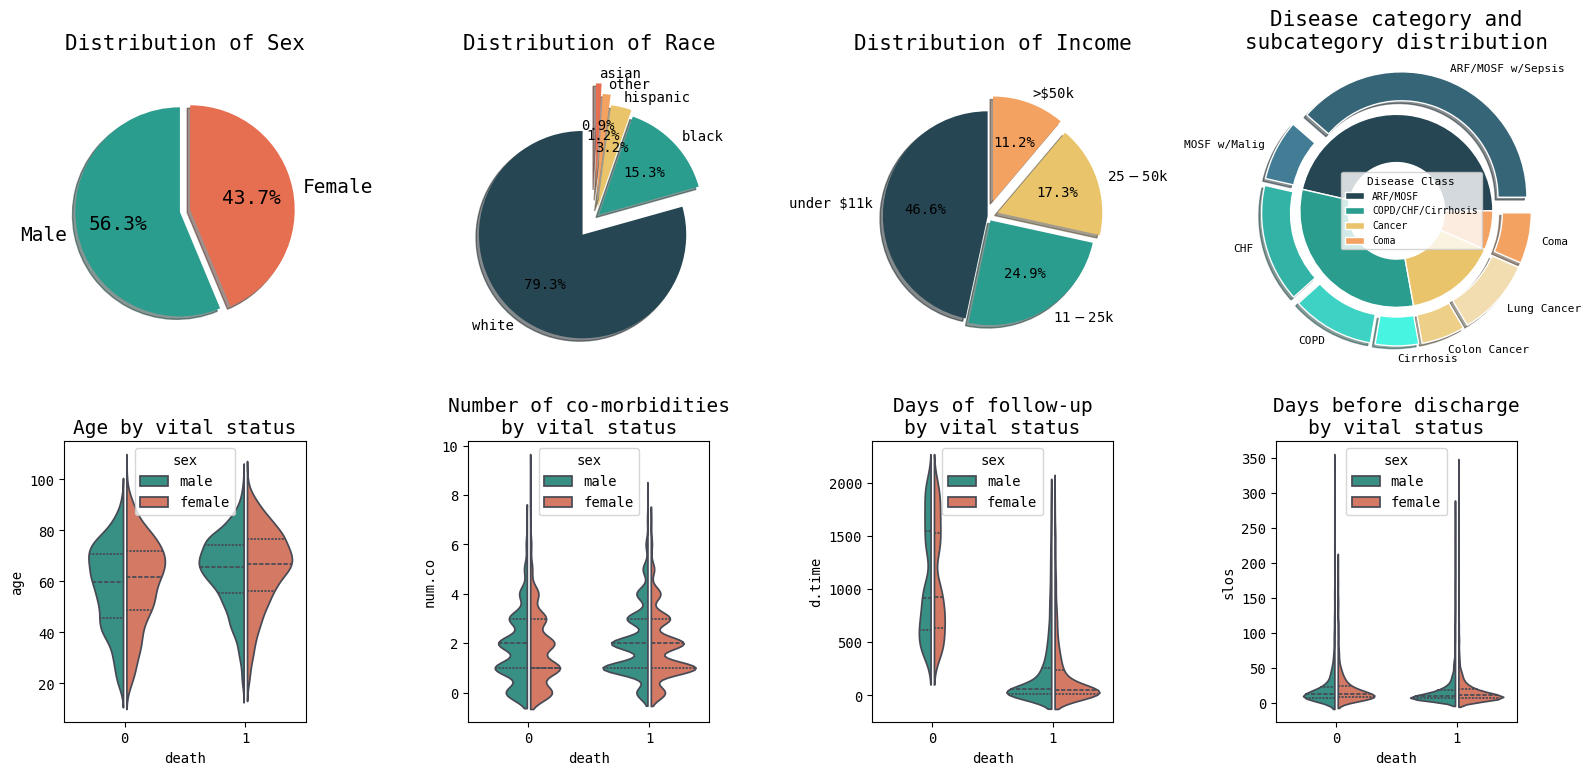

In [6]:
# I put all of my graphs in the same image so this is going to help organising them.
fig = plt.figure(figsize = (16, 8))
gs = gridspec.GridSpec(2, 4, figure = fig)

############################ 1st plot: Pie chart of the sex distribution in the study. #
ax0 = fig.add_subplot(gs[0,0])
sex_count = data_filtered['sex'].value_counts()
ax0.pie(sex_count, labels = ["Male", "Female"], autopct = '%1.1f%%', startangle = 90, 
        explode = (0, 0.1), shadow = True,
        colors = [custom_cmap_categorical.colors[1], custom_cmap_categorical.colors[4]],
        textprops = {'fontsize': 14})
ax0.set_title("Distribution of Sex", size = 15, pad = 15)
ax0.axis("equal")

############################ 2nd plot: Pie chart of the race of the patients. ########### 
ax4 = fig.add_subplot(gs[0,1])
race_count = data_filtered['race'].value_counts()
ax4.pie(race_count, labels = race_count.index, autopct = '%1.1f%%',
        startangle =90, explode = (0.2, 0.05, 0.1, 0.2, 0.3), shadow = True,
        colors = custom_cmap_categorical.colors,
        textprops = {'fontsize': 10})
ax4.set_title("Distribution of Race", size = 15, pad = 15)
ax4.axis("equal")

############################ 3rd plot: Pie chart of the income distribution in the study.#
################# (a pie chart is necessary because it is treated as categorical ranges).#
ax5 = fig.add_subplot(gs[0,2])
income_count = data_filtered['income'].value_counts()
ax5.pie(income_count, labels = income_count.index, autopct = '%1.1f%%',
        startangle = 90, explode = (0, 0.05, 0.1, 0.15), shadow = True,
        colors = custom_cmap_categorical.colors,
        textprops = {'fontsize': 10})
ax5.set_title("Distribution of Income", size = 15, pad =15)
ax5.axis("equal")

############################ 4th plot: Pie chart of the diseases distribution.#############
## First we need to prepare the data for the piechart.
# This means grouping the data in subgroups (dzgroup) which specify more information in comparison to the general disease class (dzclass)
grouped = data_filtered.groupby(['dzclass', 'dzgroup']).size().reset_index(name='count')
# Inner circle labels and size of the "slices" (general dzclass)
inner_labels = grouped.groupby('dzclass')['count'].sum().index
inner_sizes = grouped.groupby('dzclass')['count'].sum().values
# Outer circle labels and size of the "slices" (subgroups dzgroup)
outer_labels = grouped['dzgroup']
outer_sizes = grouped['count']
# Colours
inner_colors = [custom_cmap_categorical.colors[i] for i in range(len(inner_sizes))]
outer_colors = ["#376578", "#437D95", "#33B3A6", "#3DD2C3", "#47F3E1","#EECF88", "#F1DDAF","#f4a261"]

ax7 = fig.add_subplot(gs[0,3])

# Inner circle:
slices, _ = ax7.pie(inner_sizes, labels = None, radius = 1, colors = inner_colors, labeldistance = 0.15, 
                    wedgeprops = {'width' : 0.5, 
                                  'edgecolor' : 'white'}, textprops = {'fontsize': 8})
# Adding an inner legend instead of labels to improve readability.
ax7.legend(slices, inner_labels, title = "Disease Class", loc = "center left",
    bbox_to_anchor = (0.25, 0.5), fontsize = 7, title_fontsize = 8)

# Outer circle (this is going to have labels because you can read them):
ax7.pie(outer_sizes, labels = outer_labels, radius = 1.3, 
        explode = (0.15, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1), shadow = True,
       colors = outer_colors, labeldistance = 1.10,
       wedgeprops = {'width':  0.3, 
                     'edgecolor' : 'white'}, 
       textprops = {'fontsize': 8})

ax7.set(aspect = "equal")
ax7.set_title(f"Disease category and\nsubcategory distribution", size = 15, pad = 30)



############################ 5th plot: Violin plot of the age distribution (divided by vital status, coloured by sex).
ax1 = fig.add_subplot(gs[1, 0])
sns.violinplot(data = data_filtered, x = "death", y = "age", ax = ax1, legend = "brief",
               hue = "sex", split = True, inner = "quart", linecolor = "#474954", gap = 0.07,
               palette = [custom_cmap_categorical.colors[1], custom_cmap_categorical.colors[4]])
ax1.set_title("Age by vital status", size = 14)


############################ 6th plot: Violin plot of the number of comorbidities (divided by vital status, coloured by sex).
ax2 = fig.add_subplot(gs[1, 1])
sns.violinplot(data = data_filtered, x = "death", y="num.co", ax = ax2, legend ="brief",
               hue = "sex", split = True, inner = "quart", linecolor = "#474954", gap = 0.07,
               palette = [custom_cmap_categorical.colors[1], custom_cmap_categorical.colors[4]])
ax2.set_title(f"Number of co-morbidities\nby vital status", size = 14)


############################ 7th plot: Violin plot of follow-up days (divided by vital status, coloured by sex).
ax6 = fig.add_subplot(gs[1, 2])
sns.violinplot(data =data_filtered, x = "death", y = "d.time", ax = ax6, legend ="brief",
               hue = "sex", split = True, inner = "quart", linecolor = "#474954", gap = 0.07,
               palette = [custom_cmap_categorical.colors[1], custom_cmap_categorical.colors[4]])
ax6.set_title(f"Days of follow-up\nby vital status", size = 14)

############################ 8th plot: Violin plot of discharge day (divided by vital status, coloured by sex).
ax8 = fig.add_subplot(gs[1, 3])
sns.violinplot(data =data_filtered, x = "death", y = "slos", ax = ax8, legend ="brief",
               hue = "sex", split = True, inner = "quart", linecolor = "#474954", gap = 0.07,
               palette = [custom_cmap_categorical.colors[1], custom_cmap_categorical.colors[4]])
ax8.set_title(f"Days before discharge\nby vital status", size = 14)

plt.tight_layout()
plt.show()


On the third graph on the second row (the violin plots of the follow up days distribution) we can already see that there's a big difference in the time of follow-up between patients still alive by the end of the study and people pronounced dead. We can assume that the people that died were pronounced dead at the time of the last follow-up: I used this data to create a survival curve.

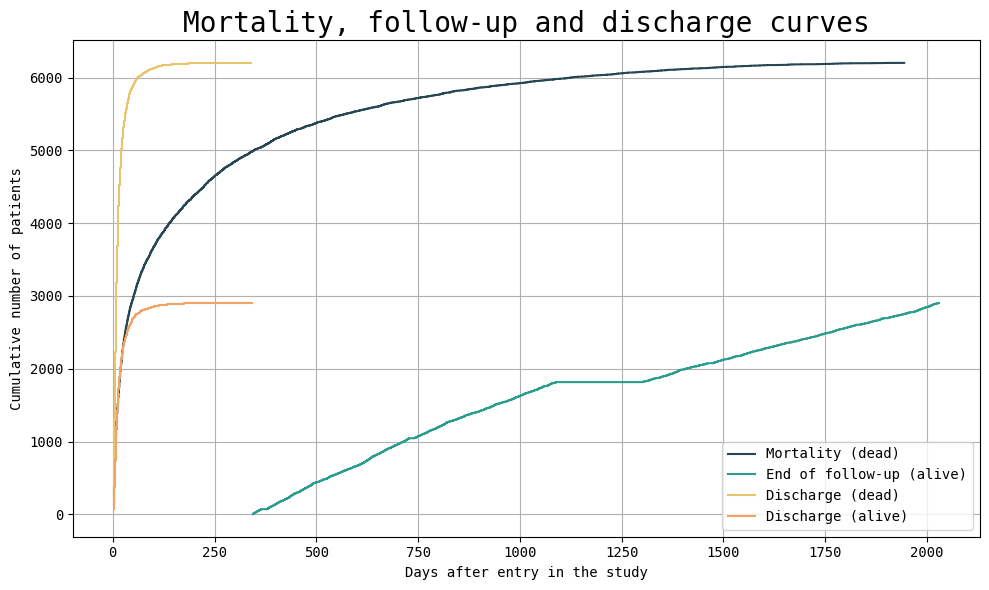

In [7]:
# 1. Mortality rate (d.time for who is pronounced dead, so death == 1)
death_data = data_filtered[data_filtered["death"] == 1]
death_curve = death_data["d.time"].value_counts().sort_index().cumsum() # These curves need to be cumulative.

# 2. Simply finish of follow-up (d.time for who is alive, so death == 0)
alive_data = data_filtered[data_filtered["death"] == 0]
alive_followup_curve = alive_data["d.time"].value_counts().sort_index().cumsum()

# 3. Discharge of people that were pronounced dead (slos, with death == 1)
discharge_dead = data_filtered[(data_filtered["death"] == 1) & (~data_filtered["slos"].isna())]
discharge_dead_curve = discharge_dead["slos"].value_counts().sort_index().cumsum()

# 4. Discharge of people that survived (slos, with death == 0)
discharge_alive = data_filtered[(data_filtered["death"] == 0) & (~data_filtered["slos"].isna())]
discharge_alive_curve = discharge_alive["slos"].value_counts().sort_index().cumsum()

# Plot
plt.figure(figsize = (10, 6))
plt.step(death_curve.index, death_curve.values, label = "Mortality (dead)",  color = custom_cmap_categorical.colors[0])
plt.step(alive_followup_curve.index, alive_followup_curve.values, label = "End of follow-up (alive)", color = custom_cmap_categorical.colors[1])
plt.step(discharge_dead_curve.index, discharge_dead_curve.values, label = "Discharge (dead)", color = custom_cmap_categorical.colors[2])
plt.step(discharge_alive_curve.index, discharge_alive_curve.values, label = "Discharge (alive)",  color = custom_cmap_categorical.colors[3])

plt.title("Mortality, follow-up and discharge curves", fontsize = 20)
plt.xlabel("Days after entry in the study")
plt.ylabel("Cumulative number of patients")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We can see that the discharge rate in both patients are the same: both people that are later on pronounced dead and those who survived throught the whole study (or which ones were alive on the last day of follow up) seems to be discharged no later than one year. The confirmation of this can be found in the next cell: both types of patient were discharged before 365 days.

In [8]:
# Max day of discharge (slos)
max_day_discharge_dead = discharge_dead["slos"].max()
max_day_discharge_alive = discharge_alive["slos"].max()

print(f"Max discharge day (dead): {max_day_discharge_dead}")
print(f"Max discharge day (alive): {max_day_discharge_alive}")
print(f'\n')

# First day of last follow up (d.time)
min_day_follow_dead = discharge_dead["d.time"].min()
min_day_follow_alive = discharge_alive["d.time"].min()
print(f"Min follow up day (dead): {min_day_follow_dead}")
print(f"Min follow up day (alive): {min_day_follow_alive}")
print(f'\n')

# Did they die (d.time) after the discharge? (slos)
same_day_dead = discharge_dead[discharge_dead["slos"] < discharge_dead["d.time"]]


print(f'People that died in total: {(data_filtered["death"] == 1).sum()}')
print(f"Patients that died after they got discharged: {len(same_day_dead)}")
print(f'People that survived in total: {(data_filtered["death"] == 0).sum()}')

Max discharge day (dead): 339
Max discharge day (alive): 343


Min follow up day (dead): 3
Min follow up day (alive): 344


People that died in total: 6201
Patients that died after they got discharged: 3841
People that survived in total: 2904


A lot of people die before they get discharged and so their "discharge" date (which in this case is artificial, because it is a "forced" discharge) reflects that: the people that die (yellow curve, that raises faster) of course have a bigger amount of patients with lower discharge date than those who survive (orange curve). 

The blue curve, which in theory is about the last follow up day for the patient that died, is actually a curve that represents their mortality rate: 2360 people die before they manage to get discharged but the majority of the people, the remaining 3841, die later, reaching a plateau around 1375 days (3 years and 9 months).

Instead, the curve that shows the follow-up days of alive patients (light blue) shows a different behaviour: it raises us slowly but steadily from the day after the last discharge (344 days) until the very last day of the study.



# 2. Cleaning up Data

## 2.1 Missing Data
I first tackled the problem of missing data: I printed the variables that have some missing values.
For some of these variables, there are some average values that can be used to replace the missing ones, as reported in the following table.

|Baseline Variable | Normal Fill-in Value |
| --- | --- |
| Serum albumin (alb) | 3.5 |
| PaO2/FiO2 ratio (pafi) | 333.3 |
|Bilirubin (bili) | 1.01 |
|Creatinine (crea) | 1.01 |
|bun | 6.51 |
|White blood count (wblc) | 9 (thousands) |
|Urine output (urine) | 2502 |

In [9]:
# Percent of missing values
missing_before = data_filtered.isnull().mean().sort_values(ascending=False)

# Recommended values to use to fill-up the missing data.
recommended = {
    "alb" : 3.5,
    "pafi" : 333.3,
    "bili" : 1.01,
    "crea" : 1.01,
    "bun" : 6.51,
    "wblc" : 9.0,
    "urine" : 2502
}

print(f"Found {len(missing_before[missing_before > 0])} variables with missing data.")
print("Substituting missing values...")

data_substituted = data_filtered.copy()

# Checks, for each column suggested in the 'recommended' dictionary, if individuals have missing data.
for x in recommended.keys():
    for individual in range(0,len(data_substituted.index)):
        if pd.isna(data_substituted[x][individual]):
            data_substituted.loc[individual, x] = recommended[x]
            
print("Finished!")

missing = data_substituted.isnull().mean().sort_values(ascending = False)
print(f"Now {len(missing[missing > 0])} variables have missing data:")
for x in missing.index:
    if missing[x] > 0:
        print(f'- {x} is missing {round(missing[x]*100, 2)}% of the data.')


Found 24 variables with missing data.
Substituting missing values...
Finished!
Now 17 variables have missing data:
- adlp is missing 61.95% of the data.
- glucose is missing 49.42% of the data.
- totmcst is missing 38.17% of the data.
- income is missing 32.75% of the data.
- adls is missing 31.49% of the data.
- ph is missing 25.09% of the data.
- edu is missing 17.95% of the data.
- sfdm2 is missing 15.38% of the data.
- totcst is missing 9.75% of the data.
- charges is missing 1.89% of the data.
- avtisst is missing 0.9% of the data.
- race is missing 0.46% of the data.
- temp is missing 0.01% of the data.
- meanbp is missing 0.01% of the data.
- hrt is missing 0.01% of the data.
- resp is missing 0.01% of the data.
- sod is missing 0.01% of the data.


The column "sfdm2", missing around 15% of data, description is: "Level of functional disability of the patient in a 1-5 scale, with 5 being the highest severity. The values were obtained via questionairres to the patient and/or surrogates to determine the Sickness Profile Impact (SIP). Values are correlated with ADLS, ADLP columns."

The categorical data corresponds to numerical values, following this relationship:

1. No signs of moderate to severe functional disability from the interview. [no(Month 2 and SIP pres)]
2. Patient was unable to do 4 or more activities of daily living. [adl>=4 (>=5 if sur)]
3. Sickness Impact Profile total score at 2 months is greater or equal to 30. [SIP>=30]
4. Patient intubated or in coma. [Coma or Intub]
5. Patient died before 2 months after study entry. [<2 mo. follow-up]

This variable can get information from others, namely: adls, adlp, adlsc, dzgroup and d.time.

In [10]:
print(f'sfdm2 missing values before imputation: {sum(data_substituted["sfdm2"].isna())}')

for individual in range(0,len(data_substituted.index)):
    if pd.isna(data_substituted["sfdm2"][individual]):
        if data_substituted["adlp"][individual] >= 4 or data_substituted["adls"][individual]>= 5 or data_substituted["adlsc"][individual] >= 5: 
            # If we have info we can simply write it 
            data_substituted.loc[individual, "sfdm2"] = "adl>=4 (>=5 if sur)" 
        elif data_substituted["dzgroup"][individual] in ("Coma","ARF/MOSF w/Sepsis"):
            # I'm assuming that somebody in acute respiratory failure (ARF) should be intubated. 
            data_substituted.loc[individual, "sfdm2"] = "Coma or Intub" 
        elif data_substituted["d.time"][individual] < 60 and data_substituted["death"][individual] == 1:
            # If somebody died within 2 months (60 days)
            data_substituted.loc[individual, "sfdm2"] = "<2 mo. follow-up" 
        elif (data_substituted["d.time"][individual] > 60 and (data_substituted["adlp"][individual] < 4 or data_substituted["adls"][individual] < 5 or data_substituted["adlsc"][individual] < 5)):
            # If somebody survived AT LEAST 60 days and from the interview it was said that "Patient was unable to do 4 or more activities of daily living"
            data_substituted.loc[individual, "sfdm2"] = 'no(M2 and SIP pres)' 

print(f'sfdm2 missing values after imputation: {sum(data_substituted["sfdm2"].isna())}')

sfdm2 missing values before imputation: 1400
sfdm2 missing values after imputation: 14


I converted it in a numerical scale: this can help the regression model and it makes sense because the categorical values reflect an increasing level of disability.

In [11]:
print(f'Values of sfdm2 before numerical conversion: {data_substituted["sfdm2"].unique()}')
print(f'Type: {data_substituted["sfdm2"].dtype}')

# Numerical values corresponding to the categorical description.
numerical_values  = {
    "adl>=4 (>=5 if sur)" : 1,
    "no(M2 and SIP pres)" : 2,
    "SIP>=30" : 3,
    "Coma or Intub" : 4,
    "<2 mo. follow-up" : 5
}

# Substitute them.
for individual in range(0, len(data_substituted.index)):
    SIP_value = data_substituted.loc[individual, "sfdm2"]
    if isinstance(SIP_value, str):
        data_substituted.loc[individual, "sfdm2"] = numerical_values[SIP_value]

data_substituted["sfdm2"] = data_substituted["sfdm2"].astype(float)

print(f'Values of sfdm2 after numerical conversion: {data_substituted["sfdm2"].unique()}')
print(f'Type: {data_substituted["sfdm2"].dtype}')

Values of sfdm2 before numerical conversion: ['adl>=4 (>=5 if sur)' '<2 mo. follow-up' 'no(M2 and SIP pres)' 'SIP>=30'
 'Coma or Intub' nan]
Type: object
Values of sfdm2 after numerical conversion: [ 1.  5.  2.  3.  4. nan]
Type: float64


## 2.2 Correlated data
Before dealing with the next missing values, I checked if there were some correlated variables that might serve the purpose of substituting those with a lot of missing data. Of course I first dropped the target value for my regression: since I want to build a regression model, it would be good to find variables highly correlated to "totcst", so deleting them would go against the goal of the first task.

In [12]:
X = data_substituted.drop(columns="totcst")
Y = data_substituted["totcst"]

I plotted the heatmap to better visualize the variables highly correlated and decide, for each couple of variables which one to delete: my decision was influenced by the amount of missing data.

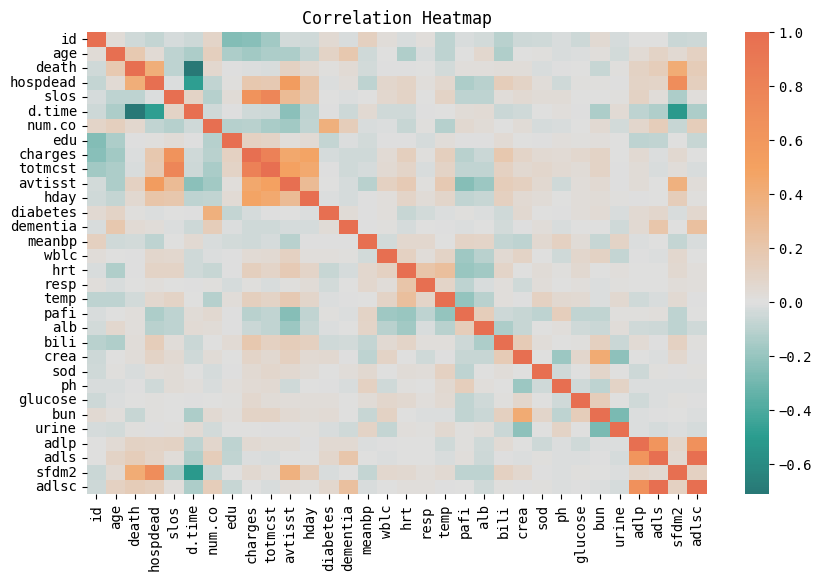

Couples very correlated (r > |0.75|): 
adls and adlsc are correlated with r = 1.00. Best to drop 'adls' (missing: 2867)
charges and totmcst are correlated with r = 0.81. Best to drop 'totmcst' (missing: 3475)
slos and totmcst are correlated with r = 0.77. Best to drop 'totmcst' (missing: 3475)


In [13]:
# Select numeric columns (heatmaps can only be built for numerical values)
numerics = X.select_dtypes(include=['float64', 'int64'])
corr_matrix = numerics.corr()

# Heatmap
plt.figure(figsize = (10,6))
sns.heatmap(corr_matrix, cmap = custom_cmap_gradient, center = 0)
plt.title("Correlation Heatmap")
plt.show()

# I obtain all correlation pairs and remove the autocorrelations and duplications
corr_pairs = corr_matrix.unstack()
corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)]
corr_pairs = corr_pairs.drop_duplicates()

# I order them and print couples with high correlation
sorted_pairs = corr_pairs.sort_values(ascending = False)
strong_corrs = [(pair, value) for pair, value in sorted_pairs.items() if abs(value) > 0.75]
print("Couples very correlated (r > |0.75|): ")

# Empty list of suggested variables to drop
suggestions = []

# Missing values for all columns
missing_all = X.isnull().sum()

for (var1, var2), corr_value in strong_corrs:
    # Missing values for the two correlated variables
    miss1 = missing_all[var1]
    miss2 = missing_all[var2]

    # Drop the variable with the highest % of missing data for each couple
    to_drop = var1 if miss1 > miss2 else var2
    suggestions.append(to_drop)

    print(f"{var1} and {var2} are correlated with r = {corr_value:.2f}. Best to drop '{to_drop}' (missing: {missing_all[to_drop]})")


to_drop_list = list(set(sorted(s for s in suggestions)))



So I decided to remove two variables: 

1. **'adls': Index of Activities of Daily Living (ADL) of the patient, filled out by a surrogate (e.g. family member), measured at day 3.** This one can be perfectly substituted by 'adlsc' (correlation = 1.00) which is "Imputed ADL Calibrated to Surrogate".
2. **'totmcst': Total micro cost** that can be substituted by both 'charges' (Hospital charges) and 'slos' (Days from Study Entry to Discharge), which are not very correlated themselves (correlation < | 0.75 |).

In [14]:
X = X.drop(columns = to_drop_list)

Now the amount missing data should be less concerning.

In [15]:
missing = X.isnull().mean().sort_values(ascending = False)

print(f"Now {len(missing[missing > 0])} variables have missing data:")
for thing in missing.index:
    if missing[thing] > 0:
        print(f'- {thing} is missing {round(missing[thing]*100, 2)}% of the data.')

Now 14 variables have missing data:
- adlp is missing 61.95% of the data.
- glucose is missing 49.42% of the data.
- income is missing 32.75% of the data.
- ph is missing 25.09% of the data.
- edu is missing 17.95% of the data.
- charges is missing 1.89% of the data.
- avtisst is missing 0.9% of the data.
- race is missing 0.46% of the data.
- sfdm2 is missing 0.15% of the data.
- meanbp is missing 0.01% of the data.
- temp is missing 0.01% of the data.
- resp is missing 0.01% of the data.
- hrt is missing 0.01% of the data.
- sod is missing 0.01% of the data.


One idea was to simply impute the missing values of glucose as the mean or median of the non missing values, but almost 50% of missing data is too much for this approach. Plus, from the heatmap, it doesn't seem to be correlated to any other numerical value, so I couldn't predict the value from them. I plotted glucose against categorical ones to see if there is some pattern that I could exploit.

C:\Users\flavi\AppData\Local\Temp\ipykernel_20344\1416965836.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=20)


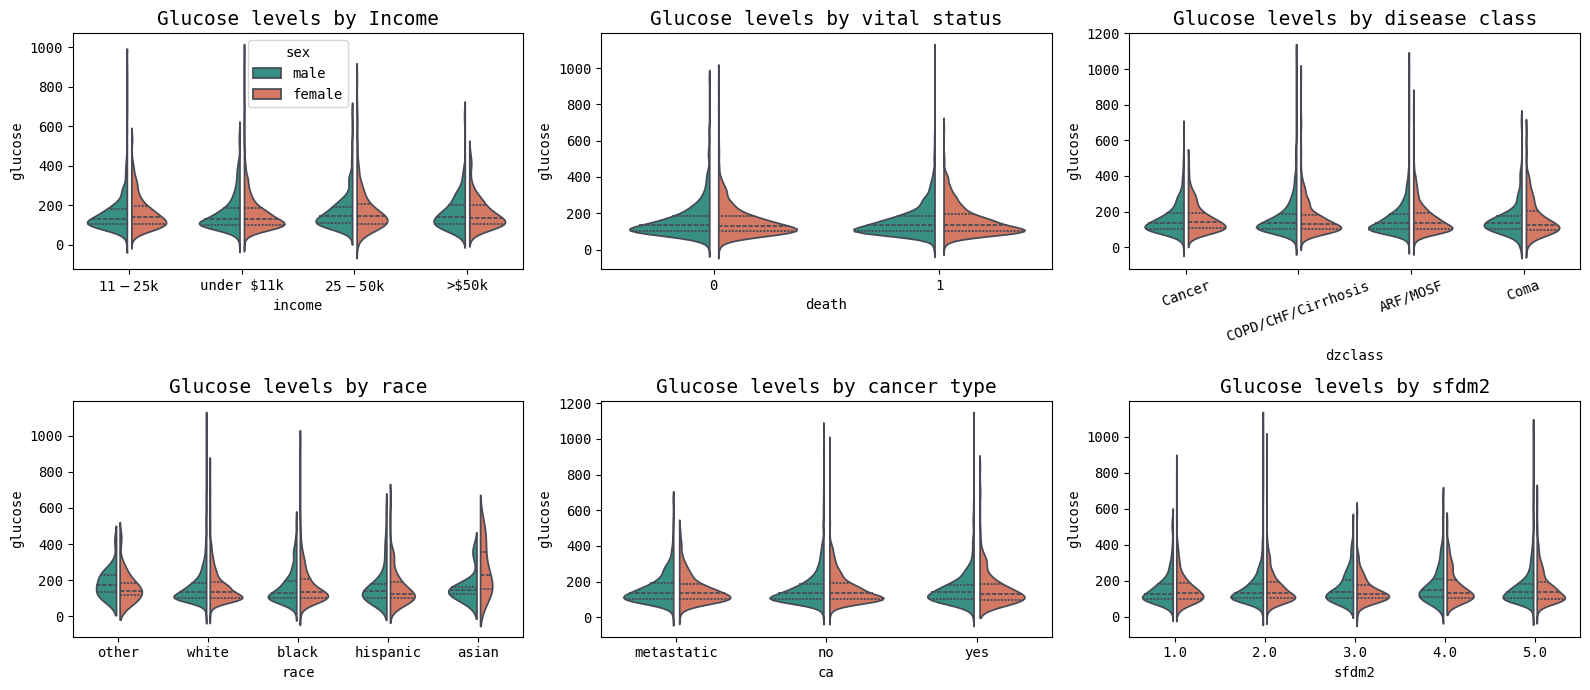

In [16]:
fig = plt.figure(figsize=(16, 7))
gs = gridspec.GridSpec(2, 3, figure = fig)

######## glucose vs income
ax0 = fig.add_subplot(gs[0,0])
sns.violinplot(data=X, x="income", y="glucose", ax = ax0, legend="brief",
               hue="sex", inner="quart", linecolor="#474954", gap = 0.1, split=True,
               palette=[custom_cmap_categorical.colors[1], custom_cmap_categorical.colors[4]])
ax0.set_title(f"Glucose levels by Income", size=14)

######## glucose vs vital status
ax1 = fig.add_subplot(gs[0,1])
sns.violinplot(data=X, x="death", y="glucose", ax = ax1, legend=False,
               hue="sex", inner="quart", linecolor="#474954", gap = 0.1, split=True,
               palette=[custom_cmap_categorical.colors[1], custom_cmap_categorical.colors[4]])
ax1.set_title(f"Glucose levels by vital status", size=14)

######## glucose vs disease class
ax2 = fig.add_subplot(gs[0,2])
sns.violinplot(data=X, x="dzclass", y="glucose", ax = ax2, legend=False,
               hue="sex", inner="quart", linecolor="#474954", gap = 0.1, split=True,
               palette=[custom_cmap_categorical.colors[1], custom_cmap_categorical.colors[4]])
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=20)
ax2.set_title(f"Glucose levels by disease class", size=14)

######## glucose vs race
ax3 = fig.add_subplot(gs[1,0])
sns.violinplot(data=X, x="race", y="glucose", ax = ax3, legend=False,
               hue="sex", inner="quart", linecolor="#474954", gap = 0.1, split=True,
               palette=[custom_cmap_categorical.colors[1], custom_cmap_categorical.colors[4]])
ax3.set_title(f"Glucose levels by race", size=14)

######## glucose vs cancer type
ax4 = fig.add_subplot(gs[1,1])
sns.violinplot(data=X, x="ca", y="glucose", ax = ax4, legend=False,
               hue="sex", inner="quart", linecolor="#474954", gap = 0.1, split=True,
               palette=[custom_cmap_categorical.colors[1], custom_cmap_categorical.colors[4]])
ax4.set_title(f"Glucose levels by cancer type", size=14)

######## glucose vs sfdm2
ax5 = fig.add_subplot(gs[1,2])
sns.violinplot(data=X, x="sfdm2", y="glucose", ax = ax5, legend=False,
               hue="sex", inner="quart", linecolor="#474954", gap = 0.1, split=True,
               palette=[custom_cmap_categorical.colors[1], custom_cmap_categorical.colors[4]])
ax5.set_title(f"Glucose levels by sfdm2", size=14)

plt.tight_layout()
plt.show()

There doesn't seem to be any cateogircal variable showing differencies in levels of glucose. I decided to delete adlp, glucose, income, ph and edu since they have more than 10% of missing data. I also drop column id for the next analyses, which might skew the analysis with a numerical value that doesn't describe anything.

In [17]:
missing_more_10 = []

for thing in missing.index:
    if round(missing[thing]*100, 2) > 10:
        missing_more_10.append(thing)

missing_more_10.append('id')

X = X.drop(columns = missing_more_10)

# 3. Regression task
In the regression task we aim to build a Regression model that can predict the totcst variable:
$$
Y_{totcst} = \beta_0 + \beta^T \cdot X
$$
We assume that the kind of relationship between the target value (Y, totcst) and the others (X) is linear.

## 3.1 Choosing the right target
I first analysed the distribution of the target value: this helped with deciding to apply transformations to it or not, to help the linear relationship between the variabbles.

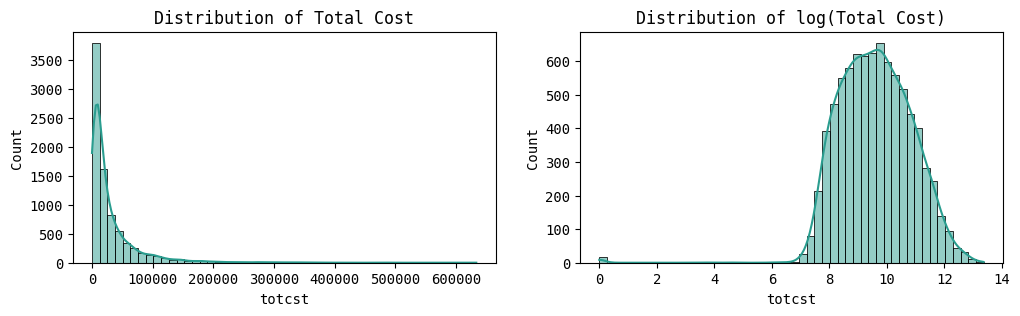

In [18]:
fig = plt.figure(figsize = (12, 3))
gs = gridspec.GridSpec(1, 2, figure=fig)

Y = data_substituted["totcst"]

######### totcst as it is
ax0 = fig.add_subplot(gs[0,0])
sns.histplot(Y, bins = 50, kde = True, color = custom_colors[1])
plt.title("Distribution of Total Cost")

target_transformed = Y.copy()
target_transformed = np.log1p(target_transformed)

########## log(totcst)
ax1= fig.add_subplot(gs[0,1])
sns.histplot(target_transformed, bins = 50, kde = True, color = custom_colors[1])
plt.title("Distribution of log(Total Cost)")
plt.show()

Y = target_transformed 

The target variable totcst shows an asymmetric distribution, skewed towards the left: to reduce this effect, I decided to apply a logarythmic transformation (log(totcst)). As shown on the graph on the right, the resulting distribution is more symmetric, resembling a normal distribution.

Since this type of distribution makes the relationship between variables closer to a linear one, I decided to use the transformed variable as our target.

## 3.2 Relationship between the target and the other variables.
To check if it would be adviable to apply a similar transformation to other variables, I plotted each variable against log(totcst): the numerical variables in scatterplots and the cathegorical and binary ones in boxplots.

C:\Users\flavi\AppData\Local\Temp\ipykernel_20344\213080412.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)
C:\Users\flavi\AppData\Local\Temp\ipykernel_20344\213080412.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)
C:\Users\flavi\AppData\Local\Temp\ipykernel_20344\213080412.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)
C:\Users\flavi\AppData\Local\Temp\ipykernel_20344\213080412.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rot

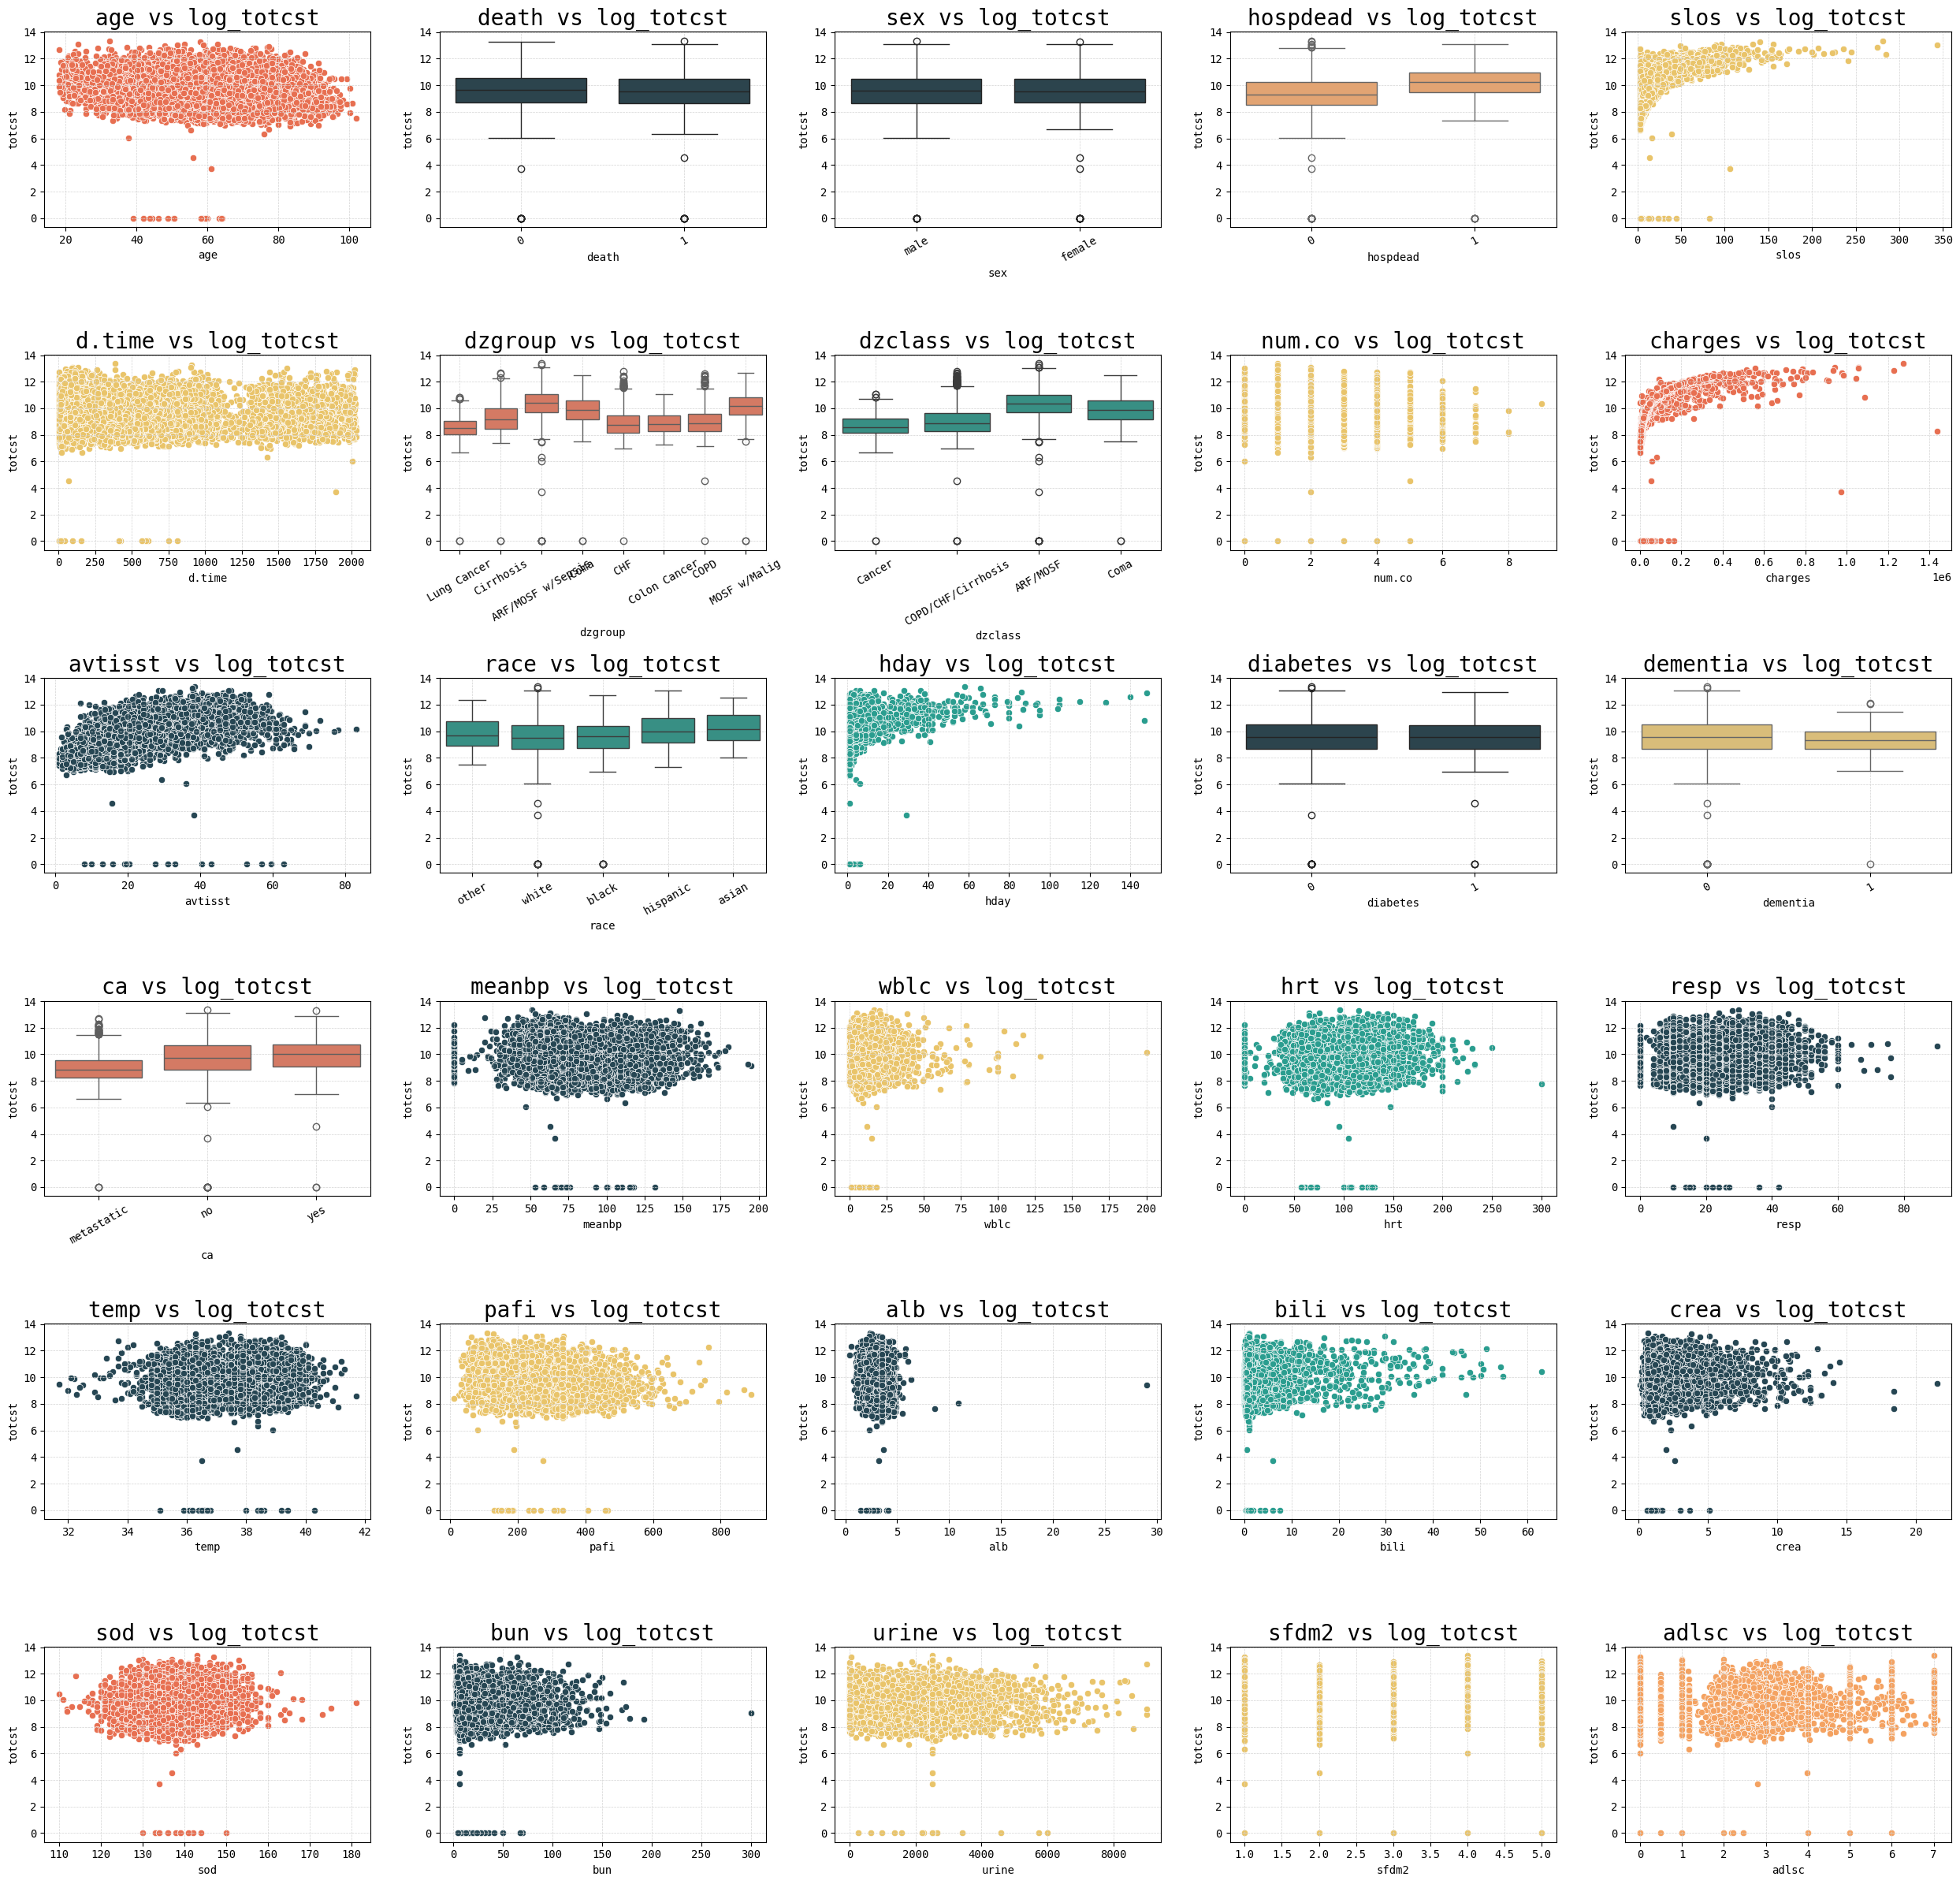

In [19]:
# Parameters for plotting
n_cols = 5

# columns to plot 
cols_to_plot = [col for col in X.columns]
n_plots = len(cols_to_plot) 

# Round by excess. I know that I have 30 plots and they're divisible in 5 columns but I don't like to hard code
n_rows = math.ceil(n_plots / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize = (n_cols*5, n_rows*4))
axes = axes.flatten()

# Plots
for i, col in enumerate(cols_to_plot):
    
    # Set axes of subplots
    ax = axes[i]

    # If variables are numeric...
    if X[col].dtype in ['int64', 'float64', 'int32', 'float32']:
        # ... first check if it's actually binary (a boxplot would be better)...
        if set(X[col].dropna().unique()) == {0, 1}:
            sns.boxplot(x = X[col], y = Y, ax = ax, color = custom_colors[random.randint(0, 4)])
            ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)
        # ... and if not, plot a scatterplot.
        else:
            sns.scatterplot(x=X[col], y = Y, ax = ax, color = custom_colors[random.randint(0, 4)])
    # ... else if they're categorical, directly plot the boxplot.
    else:
        sns.boxplot(x = X[col], y = Y, ax = ax, color = custom_colors[random.randint(0, 4)])
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)

    ax.set_title(f"{col} vs log_totcst", size = 20)
    ax.grid(True, color='lightgray', fillstyle='full', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


Then, as the last steps before building the regression model, I:

1. First removed the rows with missing values of the target totcst: these are going to be the rows predicted when a final model is chosen and fitted;
2. Changed variables 'slos', 'charges' and 'hday' to a logarithmic scale;
3. Lastly, separated the new dataset in training and test set: the latter is going to ultimately be used to validate the regression model I'm going to fit.

In [20]:
y = target_transformed 

# I temporarily merge x and y to remove missing data on totcst
data = X.copy()
data["totcst"] = y
data = data.dropna(subset=["totcst"])

# Transform in logarithmic scale the variables forementioned
data['charges'] = np.log1p(data['charges'])
data['slos'] = np.log1p(data['slos'])
data['hday'] = np.log1p(data['hday'])

# Then I finally separate my dataset
X_clean_tot = data.drop(columns=["totcst"])
y_clean_tot = data["totcst"]

# Then I divide them in train (80% of data) and test (20% of data) datasets
X_clean, X_test, y_clean, y_test = train_test_split(
    X_clean_tot, y_clean_tot, test_size = 0.2, random_state = 19
)

## 3.3 Preprocessing: dummy encoding and scaling 
Preprocessing involves the creation of a preprocessor which will:
1. Inpute missing data using the median value (for numeric variables) or the most frequent value (for cathegorical variables). As the maximum percentage of missing value for each column is less than 10% this shouldn't affect the quality of the regression model;
2. Dummy encode cathegorical variables;
3. Scale numerical variables but not binary ones.

In [21]:
# Types of columns:
# 1. Numerical columns
all_numeric = X_clean.select_dtypes(include=["int64", "float64"])

# 2. Binary columns (for example 'death' or 'hospdead') that need to be treated differently
binary_features = [col for col in all_numeric.columns if set(all_numeric[col].dropna().unique()) <= {0, 1}]

# 3. Numerical variables that are not binary
continuous_features = [col for col in all_numeric.columns if col not in binary_features]

# 4. Cathegorical variables
categorical_features = X_clean.select_dtypes(include=["object", "category"]).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('scaler', StandardScaler())
    ]), continuous_features),
    
    ("bin", Pipeline([
        ('imputer', SimpleImputer(strategy="most_frequent"))
    ]), binary_features),

    ("cat", Pipeline([
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_features)
])

## 3.4  Define the models and the scoring system
I defined the models to test and the scoring system to use: I decided to test several methods and evaluate them using both MSE (Mean Squared Error) and $R^2$.

MSE is defined as:
$$
MSE = \frac{1}{N}\cdot \sum_{i=1}^N (y_i - y_{i\_pred})^2
$$

and $R^2$ as:
$$
R^2 = 1 - \frac{RSS}{TSS} = 1 - \frac{\sum_{i=1}^N (y_i -y_{i\_pred})^2}{\sum_{i=1}^N (y_i - \overline{y})^2}
$$

A good model has ideally a low value of MSE (showing low values of error) and a value of $R^2$ close to 1.

In [22]:
models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "RandomForest": RandomForestRegressor(random_state = 19),
    "ElasticNet": ElasticNet()
}

scoring = {
    'MSE': make_scorer(mean_squared_error),
    'R2': make_scorer(r2_score)
}

## 3.5 Baseline CV comparison
I compare cross validation (10-fold) errors at first using default parameters: this can give an idea on how the models behave with no external intervention.

In [23]:
print("Cross-Validation with default parameters")
for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    scores = cross_validate(pipe, X_clean, y_clean, cv = 10, scoring = scoring)
    print(f"\n{name}:")
    print(f"  MSE: {np.mean(scores['test_MSE']):.4f}")
    print(f"  R2: {np.mean(scores['test_R2']):.4f}")

Cross-Validation with default parameters

Linear:
  MSE: 0.2743
  R2: 0.8394

Ridge:
  MSE: 0.2743
  R2: 0.8394

Lasso:
  MSE: 1.3086
  R2: 0.1866

RandomForest:
  MSE: 0.3015
  R2: 0.8216

ElasticNet:
  MSE: 0.7626
  R2: 0.5309


The Lasso model seemed to perform very poorly: a linear regression model corrected with Lasso shrinkage, is a model that finds parameters vector \beta so that it minimizes the model's RSS (Residual Sum of Squares) following this formula:

$$
min_{\beta} \left \{RSS + \lambda_2 \sum_{j = 1}^p |\beta_j|\right \}
$$

In this formula $\lambda_2$ is the **l1 penalty** which assigns a penalty to big values of $\beta$. This ends up "shrinking" the coefficients, similarly to what happens in Ridge regression, sometimes leading them even to 0, effectively performing features reduction.

A poor result in MSE and $R^2$ scores this might be caused by the choice of this l1 penalty parameter, so a good idea would be to perform hyperparameters' tuning before applying Lasso. With a parameter not correctly tuned, Lasso could force parameters to be shrinked eccessively, leading to poor results. I decided, then, to perform hyperparameters' tuning for all methods.

## 3.6 Grid search for hyperparameter tuning
I defined a scope of search of the hyperparameters I want to test in the models: this might be a slow step but it's essential to build better performing models.

The best model will be chosen using "neg_mean_squared_error" as the evaluation metric: in scikit-learn, the scoring system selects the mode with the highest score, so we calculate the opposite of MSE to make sure cross-validation minimizes it.

In [24]:
param_grids = {
    'Ridge': {'regressor__alpha': np.logspace(-4, 3, 30)},
    'Lasso': {'regressor__alpha': np.logspace(-4, 3, 30)},
    'ElasticNet': {'regressor__alpha' : np.logspace(-4, 3, 30),
                   'regressor__l1_ratio' : [0.1, 0.25, 0.5, 0.75]},
    'RandomForest': {'regressor__n_estimators': [50, 100, 200, 500], 
                     'regressor__max_depth': [None, 5, 10]}
}

best_models = {}

### 3.6.1  Grid search on more than one seed (Random Forest)
Random Forest is a stochastic method we saw for Classification tasks, but can be also used for Regression: since it is stochastic, different seeds (so different random states) might change the results. GridSearch already performs cross-validation but to make sure to not report just the results of a 'lucky' (or even unlucky) random state, I decided to try 3 different seeds and compute the mean of the results.

In this example I'm showing the result of seeds 19, 3 and 2001, but others (that I've tried) show very similar outputs.

In [25]:
print("Grid Search with random seeds (for RandomForest)")
n_seeds = 3
random_seeds = [19, 3, 2001]

# This dictionary will contain the results from all seeds
all_results_rf = {}

for seed in random_seeds:
    reg = RandomForestRegressor(random_state = seed)
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', reg)
    ])

    # The scoring of GridSearchCV tends to maximize the result...
    grid = GridSearchCV(pipe, param_grids['RandomForest'], cv = 5, scoring = 'neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_clean, y_clean)

    for i, params in enumerate(grid.cv_results_['params']):
        # ... so we're going to take the opposite of these results.
        mse = -grid.cv_results_['mean_test_score'][i]
        key = tuple(sorted(params.items()))
        
        if key not in all_results_rf:
            all_results_rf[key] = []
        
        all_results_rf[key].append(mse)

avg_results_rf = {k: np.mean(v) for k, v in all_results_rf.items()}
std_results_rf = {k: np.std(v) for k, v in all_results_rf.items()}
best_params_rf = min(avg_results_rf, key = avg_results_rf.get)

print("Best parameters for Random Forest:")
print(f"{dict(best_params_rf)}")
print(f"Mean MSE: {avg_results_rf[best_params_rf]:.4f} ± {std_results_rf[best_params_rf]:.4f}")

# Remove 'regressor__', added by the preprocessor, from keys for next steps
best_rf_params_clean = {k.replace("regressor__", ""): v for k, v in dict(best_params_rf).items()}

Grid Search with random seeds (for RandomForest)
Best parameters for Random Forest:
{'regressor__max_depth': 5, 'regressor__n_estimators': 500}
Mean MSE: 0.3127 ± 0.0003


### 3.6.2 Grid search for Ridge, Lasso and Elastic Net
These methods are fine to be evaluated just on their cross validation values results. I, though, increased the number of folds for cross-validation (instead of the 5 used for Random Forest, these two are evaluated on a 10-fold cross validation).

In [26]:
for name in ['Ridge', 'Lasso', 'ElasticNet']:
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', models[name])
    ])
    grid = GridSearchCV(pipe, param_grids[name], cv = 10, scoring = 'neg_mean_squared_error', n_jobs = -1)
    grid.fit(X_clean, y_clean)
    best_models[name] = grid.best_estimator_
    print(f"\nBest parameters for {name}: {grid.best_params_}")


Best parameters for Ridge: {'regressor__alpha': 35.622478902624444}

Best parameters for Lasso: {'regressor__alpha': 0.0016102620275609393}

Best parameters for ElasticNet: {'regressor__alpha': 0.0028072162039411755, 'regressor__l1_ratio': 0.75}


## 3.7 Re-run CV with best models
I updated the best models dictionary with all the hyperparameters found with the grid searches (Lasso, Ridge and ElasticNet were added before, so I'm only adding manually the linear and Random Forest models).

In [27]:
best_models['Linear'] = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

best_models['RandomForest'] = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state = 19, **best_rf_params_clean))
])

And then I compared CV performances again of all the models, but this time with their best hyperparameters.

In [28]:
print("Cross-Validation with best parameters:")
for name, pipe in best_models.items():
    scores = cross_validate(pipe, X_clean, y_clean, cv = 10, scoring = scoring)
    print(f"\n{name}:")
    print(f"  MSE: {np.mean(scores['test_MSE']):.4f}")
    print(f"  R2: {np.mean(scores['test_R2']):.4f}")

Cross-Validation with best parameters:

Ridge:
  MSE: 0.2742
  R2: 0.8395

Lasso:
  MSE: 0.2737
  R2: 0.8397

ElasticNet:
  MSE: 0.2737
  R2: 0.8398

Linear:
  MSE: 0.2743
  R2: 0.8394

RandomForest:
  MSE: 0.2979
  R2: 0.8242


## 3.8 Estimators of prediction errors (AIC, BIC, Adj R²) and equations
Since CV is a method to directly compute a test error, I also decided to use metrics to evaluate the performance of the models indirectly. This already gives an idea on how the models will behave on completely new data, meaning the previously splitted test data.


The formulas for AIC and BIC (Hastie, Tibshirani, Friedman (2009) – The Elements of Statistical Learning) are:
$$
  AIC = -2 \cdot log(L) + 2\cdot d
$$
$$
  BIC = -2 \cdot log(L) + d \cdot log(N)
$$
where L = likelihood and d is the number of parameters.

Under the Gaussian model, assuming the variance $\sigma_{\epsilon}^2$ is known, the $-2log(L)$ term that appears in both formulas can be approximated to $N \cdot log(\sigma_{\epsilon}^2) + \frac{error}{\sigma_{\epsilon}^2}$. 

The variance is typically estimated using the mean squared error $\sigma^2 \approx MSE$ and the error, RSS, can be approximated as $RSS \approx N \cdot MSE $.

So, putting everything together:
$$
N \cdot log(\sigma_{\epsilon}^2) \approx N \cdot log(MSE) 
$$
and 
$$
\frac{error}{\sigma_{\epsilon}^2} \approx \frac{N \cdot MSE}{MSE} = N
$$

Which means that
$$
-2 log(L) \approx N \cdot log(MSE) + N
$$

We can drop the '+ N' from the formulas because we're simply comparing models, so can then rewrite the formulas as:
$$
  AIC = N \cdot log(MSE) + 2d
$$
$$
  BIC = N \cdot log(MSE) + d \cdot log(N)
$$
and these will be the formulas I'm going to use to assess the models. BIC tends to penalize complex models more heavily, giving preference to simpler models in selection, so it's going to be used as the criterion to choose the best performing model at this step.

In [29]:
def calculate_aic_bic(model, X, y):
    """
    Calculates AIC and BIC (estimates of how the model would perform with a new set of data) for linear models that contain attribute .coef_.

    Input: 
    - model: the linear model to evaluate.
    - X: the variables.
    - y: the target.
    
    Ooutput:
    - a tuple containinc AIC and BIC scores.
    """

    y_pred = model.predict(X)
    n = len(y)
    mse = np.mean((y - y_pred)**2)

    # Number of parameters. We add one to account also for the intercept.
    if hasattr(model, 'coef_'):
        k = np.count_nonzero(model.coef_) + 1
    else:
        k = 1

    # Simplified formulas as seen in the Markdown cell
    aic = n*np.log(mse) + 2*k
    bic = n*np.log(mse) + k*np.log(n)
    return aic, bic


bic_results = {}

print("AIC/BIC of linear models")

for name, model in best_models.items():
    preprocessor = model.named_steps['preprocessor']
    estimator = model.named_steps['regressor']

    try:
        check_is_fitted(preprocessor)
    except:
        preprocessor.fit(X_clean)

    try:
        check_is_fitted(estimator)
    except:
        estimator.fit(preprocessor.transform(X_clean), y_clean)

    X_transformed = preprocessor.transform(X_clean)

    # The function can be applied only if it has the .coef_ attributes
    if hasattr(estimator, 'coef_'):
        print(f"{name} Model:")
        aic, bic = calculate_aic_bic(estimator, X_transformed, y_clean)
        print(f"AIC: {aic:.2f}, BIC: {bic:.2f}")
        bic_results[name] = bic
    else:
        pass


AIC/BIC of linear models
Ridge Model:
AIC: -8501.72, BIC: -8175.76
Lasso Model:
AIC: -8528.63, BIC: -8324.91
ElasticNet Model:
AIC: -8527.88, BIC: -8337.74
Linear Model:
AIC: -8503.74, BIC: -8177.79


The model that best performs when evaluated indirectly (lowest BIC), is:

In [30]:
best_model_bic = min(bic_results, key=bic_results.get)
print(f"{best_model_bic} (BIC = {bic_results[best_model_bic]:.2f})")

ElasticNet (BIC = -8337.74)


For Random Forest, visualization is slightly different: instead of having coefficients for each variable, I can compare the "importance" of each of them.

C:\Users\flavi\AppData\Local\Temp\ipykernel_20344\2353285399.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = feature_importance_df.head(20), x = 'Importance', y = 'Feature', palette = custom_colors)
C:\Users\flavi\AppData\Local\Temp\ipykernel_20344\2353285399.py:19: UserWarning: 
The palette list has fewer values (5) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data = feature_importance_df.head(20), x = 'Importance', y = 'Feature', palette = custom_colors)


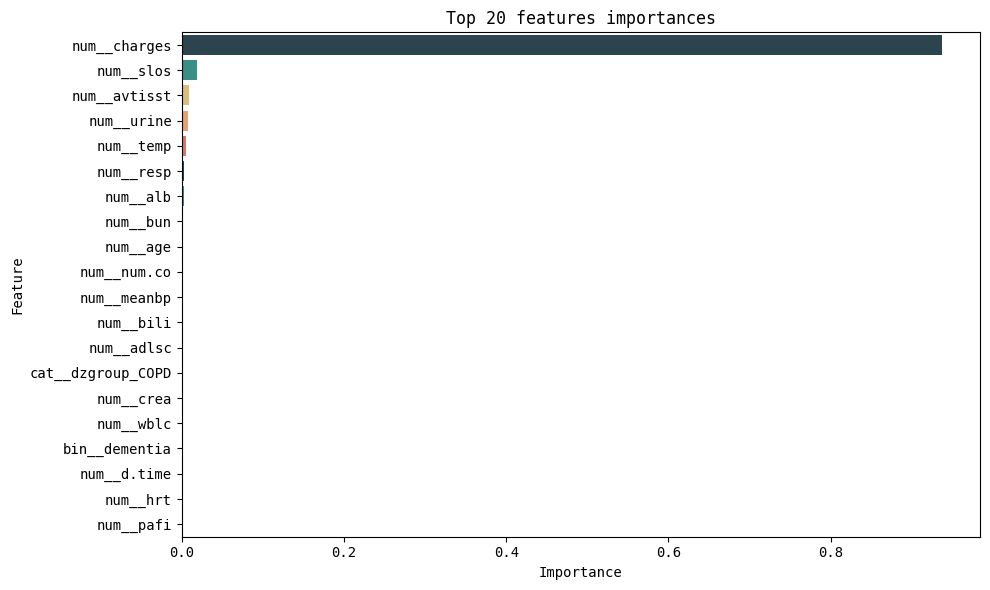

In [31]:
# Fit the best model (using pipeline saved in best_models) on the data
best_models['RandomForest'].fit(X_clean, y_clean)

# Names of features.
feature_names = preprocessor.get_feature_names_out()

# Gather the importance of each variable.
rf_model = best_models['RandomForest'].named_steps['regressor']
importances = rf_model.feature_importances_

# Order them in a dataframe, so I can order them by importance.
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by = 'Importance', ascending = False)

# Plot
plt.figure(figsize = (10, 6))
sns.barplot(data = feature_importance_df.head(20), x = 'Importance', y = 'Feature', palette = custom_colors)
plt.title("Top 20 features importances")
plt.tight_layout()
plt.show()

Although the Random Forest model includes all variables, they have very different importance. An important question might be: how many are those that represent at least 1% of the importance in the model?

In [32]:
threshold = 0.01
selected_features = feature_importance_df[feature_importance_df['Importance'] > threshold]['Feature'].tolist()
print(f"Selected features (importance > {round(threshold*100,2)}%): {selected_features}")

Selected features (importance > 1.0%): ['num__charges', 'num__slos']


Just 'charges' (charges from the hospital) and 'slos' (discharge time). This makes conceptually a lot of sense: a person staying longer in the hospital and requiring more expensive or simply a bigger amount of treatments, will raise the total cost.

## 3.9 Comparison between train and test error

Up until now I've only tried my models over the train set: although cross-validation is a good method to assess already the quality of the models, the last test, which is also very robust, can be done over the remaining 20% of the original data, the test test. This is a totally new set of data for the previously fitted models.

In [33]:
results = {}

for name, model in best_models.items():
    print(f'Predicting {name}...')
    
    # I clone the models to avoid anything happening to the stored ones.
    model2 = clone(model)
    model2.fit(X_clean, y_clean)

    # Prediction on train
    y_pred_train = model2.predict(X_clean)

    # Ealuation of this prediction
    mse_train = mean_squared_error(y_clean, y_pred_train)
    r2_train = r2_score(y_clean, y_pred_train)

    # Prediction on test
    y_pred_test = model2.predict(X_test)

    # Evaluation of this other prediction
    mse_test = mean_squared_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)

    results[name] = {
        'MSE_train': mse_train,
        'R2_train': r2_train,
        'MSE_test': mse_test,
        'R2_test': r2_test
    }

results_df = pd.DataFrame(results).T.sort_values('MSE_test')
print(f'\n')
print("Models comparison:")
print(results_df)

# Best model: 
name = results_df.index[0]

Predicting Ridge...
Predicting Lasso...
Predicting ElasticNet...
Predicting Linear...
Predicting RandomForest...


Models comparison:
              MSE_train  R2_train  MSE_test   R2_test
ElasticNet     0.270920  0.831443  0.282313  0.825323
Lasso          0.270725  0.831565  0.282491  0.825213
Ridge          0.270351  0.831798  0.283617  0.824516
Linear         0.270267  0.831850  0.283666  0.824486
RandomForest   0.189400  0.882162  0.302687  0.812717


Although Random Forest performs better during the training, the models perform relatively similarly to each other during the testing, with some performing better than others. The model chosen to predict the missing values of totcst is:

In [34]:
print(name)

ElasticNet


Random Forest's train error tends to zero the more we raise the number of estimators: while performing grid-search I tried also setting n_estimators up to 2000 and this always raises the R-squared of the train set, so the highest n_estimators tends to get chosen during grid-search. But it always lowers the R-squared of the test set: probably it is a case of overfitting. I concluded that higher n_estimators leads to over-fitting of the data and also increases greatly the time required for the grid-search, that's why I didn't include these values before.

## 3.10 Prediction 
Now that the model (with its best paramaters) is chosen, it can be used to predict the missing data.
### 3.10.1 Fit the model on the whole dataset
First, though, the model needs to fit again, this time over the full data and not just on the 80% of it (train data).

In [35]:
# Clone the best model to access it but not modify it
lasso_copy = clone(best_models[name])

# Fit it now on the whole dataset (and not just on the train set)
lasso_copy.fit(X_clean_tot, y_clean_tot)

print("Tuned model cross validation on the whole dataset")
scores = cross_validate(pipe, X_clean_tot, y_clean_tot, cv = 10, scoring = scoring)
print(f"  MSE: {np.mean(scores['test_MSE']):.4f}")
print(f"  R2: {np.mean(scores['test_R2']):.4f}")
print(f'\n')

preprocessor = lasso_copy.named_steps['preprocessor']
estimator = lasso_copy.named_steps['regressor']

feature_names = preprocessor.get_feature_names_out()
coeffs = estimator.coef_
intercept = estimator.intercept_

# Some coefficients might be shrinked a lot towards 0.
# For the sake of equation readability, we print two versions of the equation:
# 1. The complete one;
# 2. The one excluding coefficients smaller than 1e-6.
zero_coeff_count = np.sum(np.abs(coeffs) < 1e-6)
nonzero_coeff_count = np.sum(np.abs(coeffs) >= 1e-6)

print(f"Number of non-zero coefficients: {nonzero_coeff_count}")
print(f"Number of zero* coefficients: {zero_coeff_count}")
print(f'*By zero, I mean coefficient < 1e-6')
print(f'\n')

# 1. Complete equation
terms_full = [f"{coef:.4f}*{fname}" for coef, fname in zip(coeffs, feature_names)]
equation_full = f"y = {intercept:.4f} + " + " + ".join(terms_full)

print(f"Complete equation of model {name}")
print(equation_full)
print(f'\n')

# 2. Reduced equation
nonzero_pairs = [(fname, coef) for fname, coef in zip(feature_names, coeffs) if abs(coef) >= 1e-6]
# I also order them (decreasing order, using the absolute value of the coefficient) so we can immediately have an idea of the most important features
nonzero_pairs_sorted = sorted(nonzero_pairs, key = lambda x: -abs(x[1]))

terms_filtered = [f"{coef:.4f}*{fname}" for fname, coef in nonzero_pairs_sorted]
equation_filtered = f"y = {intercept:.4f} + " + " + ".join(terms_filtered)

print(f"Reduced equation of model {name}")
print(equation_filtered)


Tuned model cross validation on the whole dataset
  MSE: 0.3159
  R2: 0.8238


Number of non-zero coefficients: 28
Number of zero* coefficients: 19
*By zero, I mean coefficient < 1e-6


Complete equation of model ElasticNet
y = 9.5784 + -0.0047*num__age + 0.2756*num__slos + 0.0061*num__d.time + -0.0315*num__num.co + 0.8231*num__charges + 0.0695*num__avtisst + 0.0796*num__hday + 0.0047*num__meanbp + 0.0080*num__wblc + 0.0013*num__hrt + -0.0017*num__resp + -0.0057*num__temp + -0.0033*num__pafi + 0.0000*num__alb + -0.0000*num__bili + 0.0208*num__crea + 0.0000*num__sod + -0.0380*num__bun + -0.0070*num__urine + 0.0000*num__sfdm2 + -0.0019*num__adlsc + 0.0150*bin__death + 0.0647*bin__hospdead + 0.0159*bin__diabetes + -0.0000*bin__dementia + -0.0095*cat__sex_female + 0.0008*cat__sex_male + 0.0000*cat__dzgroup_ARF/MOSF w/Sepsis + 0.0000*cat__dzgroup_CHF + -0.0242*cat__dzgroup_COPD + 0.0000*cat__dzgroup_Cirrhosis + -0.0000*cat__dzgroup_Colon Cancer + -0.0000*cat__dzgroup_Coma + -0.0147*cat__dzg

### 3.10.2 Predict the missing values.

Now that the model is fit on the whole train data, we can use I used it to predict the values of totcst for the individuals that had NA values for it.

In [36]:
# Find the index of missing values from the very first dataset
missing_idx = y[y.isna()].index

# Obtain the variables data from the same index.
X_missing = X.loc[missing_idx]

# Transform in logarithmic scale the values of charges, slos and hday.
X_missing['charges'] = np.log1p(X_missing['charges'])
X_missing['slos'] = np.log1p(X_missing['slos'])
X_missing['hday'] = np.log1p(X_missing['hday'])

# We use model lasso_copy which was fitted on the whole dataset.
y_pred_missing = lasso_copy.predict(X_missing)

pred_df = pd.DataFrame({
    "Index": missing_idx,
    "Predicted Target": y_pred_missing
})

The dataset now contains all the values of tot_cst. (I didn't want to overwrite it, so I created a copy).

In [37]:
# Copy the original dataset
y_filled = y.copy()

# Add the missing data
y_filled.loc[missing_idx] = y_pred_missing

I ploted the known values and the new predicted ones to see if they follow a similar curve: I decided to plot them against log('charges'), being the variables with the highest absolute value of coefficient in the model (as well as the one with the highest importance in Random Forest).

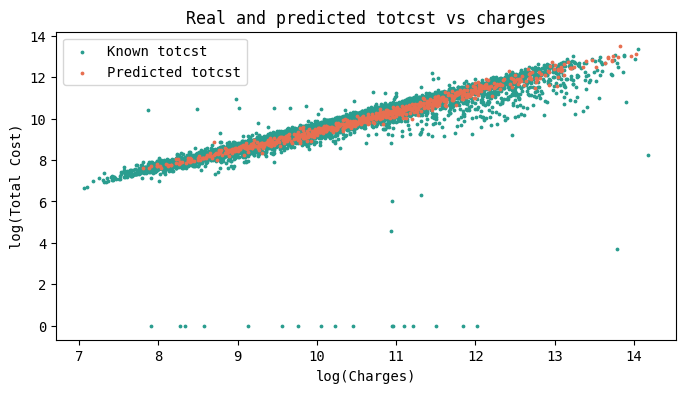

In [38]:
# Index of already known data from the original dataset (y)
known_idx = y[~y.isna()].index

# Values of charges divided in:
# 1. From dataset of (originally) known variables of totcst (I have to transform them into logarithmic form)
charges_known = X.loc[known_idx, 'charges']
charges_known = np.log1p(charges_known)
# 2. From dataset of (originally) not known variables of totcst (No need to transform them, already did in the previous code cell)
charges_missing = X_missing['charges']

# The known values of totcst were already present in the y_clean_tot, but for the sake of coherence, I extract them using the known_idx used already for values of charges
y_known = y.loc[known_idx]


plt.figure(figsize=(8,4))

# Original points (known target)
plt.scatter(charges_known, y_known, color=custom_colors[1], label='Known totcst', s = 3)

# Predicted points
plt.scatter(charges_missing, y_pred_missing, color=custom_colors[4], label='Predicted totcst', s = 3)

plt.xlabel('log(Charges)')
plt.ylabel('log(Total Cost)')
plt.title('Real and predicted totcst vs charges')
plt.legend()
plt.show()


The red dots (representing the predicted values) closely follow the real values (those coming from the dataset itself) so the regression model is robust and reliable.

# 4. Classification task
The goal of this task is to construct a model that can predict if a patient died before the end of 1994. The target variable is 'death' (that we saw takes 0 as a value if the patient survived until the very last possible follow-up and 1 if, instead, they were pronounced dead).

I assumed the task wanted to identify ways to predict if the patient will die, using **only the information available at the time of admission at the hospital**. We mean all the tests done and the diagnosis, but not the count of days spent at the hospital and the days of follow-up (both shorter for people that died, this information is collected after death happens).

## 4.1 Further pre-processing
I used the dataset I cleaned up from the missing and correlated data, but I dropped a few columns as they directly DEPEND on if and when the patient died, and cannot predict it. These columns are "hospdead" (wether or not the patient died in the hospital), "slos" (discharge time, shorter if the person died in the hospital), "d.time" (follow-up days, less if the patient died), "totcst" and "charges" (as we've seen, totcst depends very heavily on charges, which stop raising when a patient dies).

In [39]:
# Our cleaned dataset is saved in X and full tot_cst column is saved in y_filled

# Our new full dataset is going to be copied from the cleaned X dataset from the regressiont task
dataset = X.copy() 

# I can separate target from data
y_classification = dataset["death"]
X_classification = dataset.drop(columns=["death", "hospdead", "d.time", "slos", "charges"])

# As before I split in train and test set
X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(
    X_classification, y_classification, test_size=0.2, random_state = 19
)

Again, features need to be imputed and scaled beforehand, so I needed to process the columns in different ways depending on the type of values they contained.

In [40]:
# Types of columns:
# 1. Numerical columns
all_numeric = X_class_train.select_dtypes(include=["int64", "float64"])

# 2. Binary columns (for example 'death' or 'hospdead') that need to be treated differently
binary_features = [col for col in all_numeric.columns if set(all_numeric[col].dropna().unique()) <= {0, 1}]

# 3. Numerical variables that are not binary
continuous_features = [col for col in all_numeric.columns if col not in binary_features]

# 4. Cathegorical variables
categorical_features = X_class_train.select_dtypes(include=["object", "category"]).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('scaler', StandardScaler())
    ]), continuous_features),
    
    ("bin", Pipeline([
        ('imputer', SimpleImputer(strategy="most_frequent"))
    ]), binary_features),

    ("cat", Pipeline([
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_features)
])

## 4.2 Definition of models to test
I define all the models to test:
- Logistic regression ("Normal", Ridge, Lasso and Elastic net);
- K Nearest Neighbors;
- Linear Discriminant analysis (LDA);
- Quadratic Discriminant analysis (QDA);
- Support vector classifier (SVC) for which I tested radial basis, linear and polynomial kernels;
- Random Forest;
- Neural network.

In [41]:
seed = 19

models = {
    "Logistic Regression": LogisticRegression(penalty = None, max_iter = 2000, random_state = seed), # I hardcode the maximum number of iterations
    "Ridge Logistic Regression" : LogisticRegression(penalty = 'l1', max_iter = 2000, random_state = seed),
    "Lasso Logistic Regression" : LogisticRegression(penalty = 'l2', max_iter = 2000, random_state = seed),
    "Elastic Net Logistic Regression" : LogisticRegression(penalty = 'elasticnet', solver = 'saga', max_iter = 1000, random_state = seed),
    "KNN": KNeighborsClassifier(),
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis(),
    "SVM": SVC(probability = True, random_state = seed), # This already uses 5 fold cross validation
    "Random Forest": RandomForestClassifier(random_state = seed),
    "Neural Network": MLPClassifier(max_iter = 1000, random_state = seed)
}

## 4.3 Grid Search
As I already confirmed with regression that models on this dataset perform better after grid search (see Lasso Regression's MSE before and after hyperparameters tuning), I skip testing the models with default parameters and directly perform Grid Search.

In [42]:
param_grids = {"Logistic Regression": {'classifier__solver': ['saga', 'lbfgs']},
                "Ridge Logistic Regression": {'classifier__C': [0.01, 0.1, 1, 10, 20, 30],
                                              'classifier__solver': ['saga', 'liblinear']},
                "Lasso Logistic Regression": {'classifier__C': [0.01, 0.1, 1, 10, 20, 30],
                                              'classifier__solver': ['saga', 'lbfgs', 'liblinear']},
                "Elastic Net Logistic Regression" : {'classifier__C': [0.01, 0.1, 1, 10, 20, 30],
                                       'classifier__l1_ratio' : [0.1, 0.25, 0.5, 0.75]},
                "KNN": {'classifier__n_neighbors': [3, 5, 7, 9],
                        'classifier__weights' : ['uniform', 'distance'],
                        'classifier__p' : [1.0, 2.0]},
                "LDA": {'classifier__solver' : ['svd', 'lsqr', 'eigen']},
                "QDA": {'classifier__reg_param': [0.0, 0.01, 0.1, 0.5, 0.7, 0.8, 0.9, 1.0]},
                "SVM": {'classifier__C': [0.01, 0.1, 1, 10],
                              'classifier__kernel' : ['rbf', 'linear', 'poly'],
                              'classifier__degree' : [3, 4, 5],
                              'classifier__gamma' : ['scale', 'auto']},
                "Random Forest": {'classifier__n_estimators': [50, 100, 200, 500], 
                                  'classifier__max_depth': [None, 5, 10]},
                "Neural Network": {'classifier__hidden_layer_sizes' : [50, 100],
                                   'classifier__solver' : ['sgd', 'lbfgs', 'adam'],
                                   'classifier__alpha' : np.logspace(-6, 1, 16)}
                                   }

best_models = {}

Given the amount of models and the parameters to test, this step takes quite long (around 15-20 minutes). The best model is chosen using "f1-score" which is calculated as (scikit-learn documentation):
$$
F1 = \frac{2*TP}{2*TP + FP + FN}
$$
where:
- TP = true positives;
- FP = false positives;
- FN = false nefatives.

It supports beyond binary targets, but it's especially efficient in them, so since I only had two classes (death or alive) I decided to use this.

Some runs of the cross validation of the models don't converge: this doesn't affect the outcome, so, to improve readibility of the results, I silenced the warnings. That command can be deleted or commented to show when and how that happens.

In [43]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 19)
best_models = {}

for name, model in models.items():
    with warnings.catch_warnings():
        # Silencing of the warnings just for a better output
        warnings.filterwarnings("ignore", category = ConvergenceWarning)
        warnings.filterwarnings("ignore", category = UserWarning)

        print(f"Training {name}...")
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])

        param_grid = param_grids[name]

        # Grid search performs 5-fold cross validation.
        grid = GridSearchCV(pipe, param_grid, cv = cv, scoring='f1', n_jobs=-1)
        grid.fit(X_class_train, y_class_train)

        # Notes down the best parameters for each model.
        best_models[name] = grid.best_estimator_

        print(f"Best params for {name}: {grid.best_params_}")
        print(f'\n')


Training Logistic Regression...
Best params for Logistic Regression: {'classifier__solver': 'saga'}


Training Ridge Logistic Regression...
Best params for Ridge Logistic Regression: {'classifier__C': 10, 'classifier__solver': 'saga'}


Training Lasso Logistic Regression...
Best params for Lasso Logistic Regression: {'classifier__C': 0.01, 'classifier__solver': 'saga'}


Training Elastic Net Logistic Regression...
Best params for Elastic Net Logistic Regression: {'classifier__C': 0.01, 'classifier__l1_ratio': 0.1}


Training KNN...
Best params for KNN: {'classifier__n_neighbors': 9, 'classifier__p': 2.0, 'classifier__weights': 'uniform'}


Training LDA...


C:\Users\flavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\flavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\flavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packag

Best params for LDA: {'classifier__solver': 'svd'}


Training QDA...
Best params for QDA: {'classifier__reg_param': 0.9}


Training SVM...
Best params for SVM: {'classifier__C': 1, 'classifier__degree': 3, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}


Training Random Forest...
Best params for Random Forest: {'classifier__max_depth': 10, 'classifier__n_estimators': 500}


Training Neural Network...
Best params for Neural Network: {'classifier__alpha': 1.165914401179831, 'classifier__hidden_layer_sizes': 50, 'classifier__solver': 'sgd'}




## 4.4 Evaluation
I then performed and showed the results of evaluation (using ROC) on the training and test set of the models with the best parameters. I ordered them by test AUC (Area under the curve, which should preferably be close to 1) to choose the best performing model at this step.

In [44]:
cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 19)

results = []

# The actions are similar to what was done for the regression, but the scoring system is different.
scoring = {'accuracy': 'accuracy', 'f1': 'f1', 'roc_auc': 'roc_auc'}

for name, best_model in best_models.items():
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        warnings.filterwarnings("ignore", category=UserWarning)
        
        print(f"Evaluating {name}...")

        # Cross-validation on train set
        cv_scores = cross_validate(best_model, X_class_train, y_class_train, cv = cv, scoring = scoring)

        # Prediction on test set
        y_test_pred = best_model.predict(X_class_test)
        y_test_proba = best_model.predict_proba(X_class_test)[:, 1]

        results.append({
            "Model": name,
            "Train Accuracy (CV)": np.mean(cv_scores['test_accuracy']),
            "Train F1 (CV)": np.mean(cv_scores['test_f1']),
            "Train AUC (CV)": np.mean(cv_scores['test_roc_auc']),
            # Here the comparison between train and test y is done:
            "Test Accuracy": accuracy_score(y_class_test, y_test_pred),
            "Test F1": f1_score(y_class_test, y_test_pred),
            "Test AUC": roc_auc_score(y_class_test, y_test_proba)
        })

# Printing of results
print(f'\n')
print('Results:')
df_results = pd.DataFrame(results)
df_results.sort_values(by = "Test AUC", ascending = False, inplace = True)
df_results.reset_index(drop = True, inplace = True)
df_results


Evaluating Logistic Regression...
Evaluating Ridge Logistic Regression...
Evaluating Lasso Logistic Regression...
Evaluating Elastic Net Logistic Regression...
Evaluating KNN...
Evaluating LDA...
Evaluating QDA...
Evaluating SVM...
Evaluating Random Forest...
Evaluating Neural Network...


Results:


Model  Train Accuracy (CV)  Train F1 (CV)  \
0                    Random Forest             0.798054       0.854973   
1                   Neural Network             0.793382       0.851487   
2                              SVM             0.791323       0.850016   
3                              LDA             0.774437       0.836873   
4        Ridge Logistic Regression             0.771005       0.835589   
5              Logistic Regression             0.771280       0.835787   
6        Lasso Logistic Regression             0.768535       0.836769   
7  Elastic Net Logistic Regression             0.767299       0.836203   
8                              QDA             0.762217       0.833086   
9                              KNN             0.765511       0.831755   

   Train AUC (CV)  Test Accuracy   Test F1  Test AUC  
0        0.883417       0.798462  0.852433  0.881706  
1        0.877002       0.785832  0.843499  0.873953  
2        0.863190       0.785283  0.843412  0.864192  
3        0.850165       0.766612  0.829249  0.845327  
4        0.850860       0.765513  0.830084  0.845259  
5        0.850863       0.765513  0.830084  0.845237  
6        0.849866       0.759473  0.829572  0.842815  
7        0.849751       0.756727  0.827827  0.840756  
8        0.832615       0.745744  0.820334  0.825747  
9        0.822565       0.768259  0.830929  0.823125

The results show that, very probably, the boundary between the two classes is not linear: this is confirmed by Support Vector Machine choosing a radial basis kernel (and not a linear one), and all the linear classifiers performing similarly (3-7).

## 4.5 Best model (Random Forest) visualization
Warning: in this case I had to hard code the visualization of features importance, which is typical of Random Forest. Although I doubt it would happen, if other seeds conclude that the best model is another one different from Random Forest, automatically retrieving the name of the best model would break and stop the following code. Hence why I hard coded the name of the best model.

The first part visualizes the ROC curve and the confusion matrix of the model and should work with every type of classifier: just skip the second part of the code in case visualization of another model is desired.

Model performance on test set


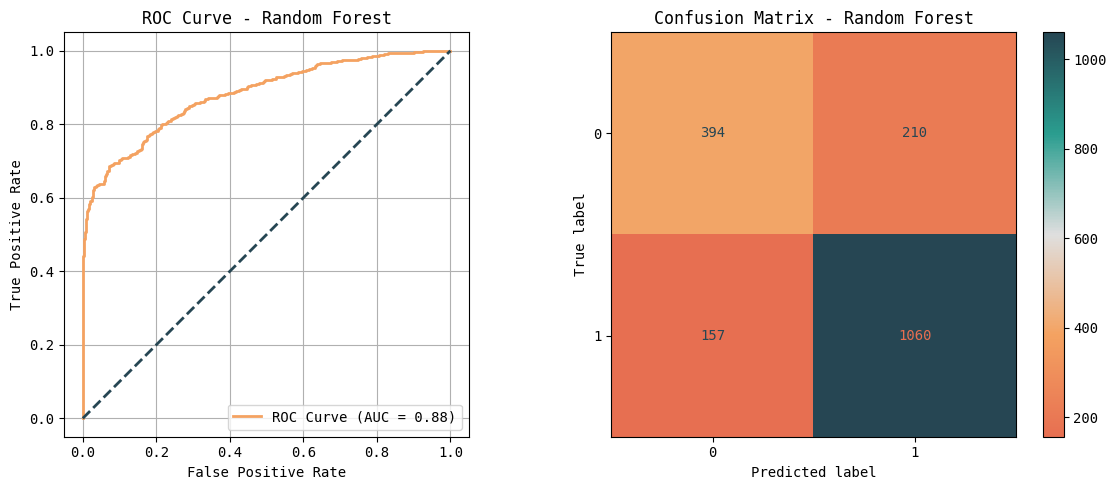



Features' importance of Random Forest model fitted on full dataset


C:\Users\flavi\AppData\Local\Temp\ipykernel_20344\3433348776.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = filtered_importances, y = filtered_features, palette = colors)


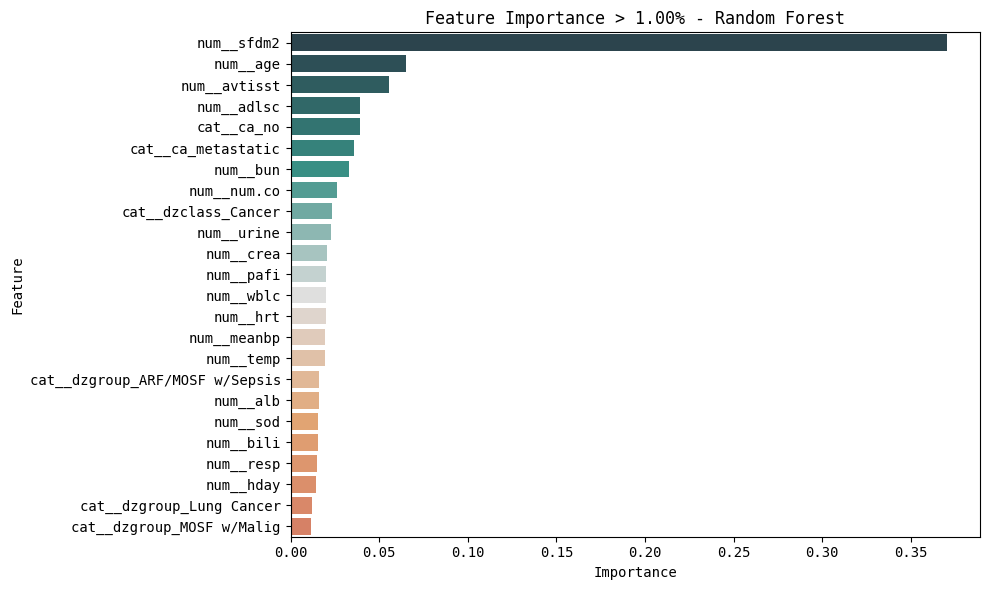

In [45]:
# Retrieve best model
pipeline_rf = best_models['Random Forest']

############################################ Preparation of data
# Predict probabilities
y_score = pipeline_rf.predict_proba(X_class_test)[:, 1]

# Compute false positive rate (Type I error) and True positive rate (Sensitivity or Power or Recall) for ROC curve
false_pos_rate, true_pos_rate, _ = roc_curve(y_class_test, y_score)
roc_auc = auc(false_pos_rate, true_pos_rate)

# Predict y for Confusion Matrix
y_pred = pipeline_rf.predict(X_class_test)
conf_matrix = confusion_matrix(y_class_test, y_pred)

############################################# Visualization
print(f'Model performance on test set')
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ROC CURVE
axes[0].plot(false_pos_rate, true_pos_rate, color = custom_colors[3], lw = 2, label = f'ROC Curve (AUC = {roc_auc:.2f})')
axes[0].plot([0, 1], [0, 1], color = custom_colors[0], lw = 2, linestyle='--')
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curve - Random Forest")
axes[0].legend(loc = "lower right")
axes[0].grid(True)
axes[0].set(aspect = "equal")

# CONFUSION MATRIX
conf_matrix_plot = ConfusionMatrixDisplay(confusion_matrix = conf_matrix)
conf_matrix_plot.plot(cmap = custom_cmap_gradient.reversed(), ax = axes[1], colorbar = True)
axes[1].set_title("Confusion Matrix - Random Forest")
axes[1].set(aspect="equal")

plt.tight_layout()
plt.show()

print(f'\n')
########################################################## Refit on full model and features importance
pipeline_rf_final = clone(pipeline_rf)
pipeline_rf_final.fit(X_classification, y_classification)

# Features' importance
rf_model = pipeline_rf_final.named_steps['classifier']
preprocessor = pipeline_rf_final.named_steps['preprocessor']
feature_names = preprocessor.get_feature_names_out()
importances = rf_model.feature_importances_

# Filter and sorting of features' importance
feature_names = np.array(feature_names)
importances = np.array(importances)

filtered_features = feature_names[importances > 0.01]
filtered_importances = importances[importances > 0.01]

sorted_indices = np.argsort(filtered_importances)[::-1]
filtered_features = filtered_features[sorted_indices]
filtered_importances = filtered_importances[sorted_indices]

n = len(filtered_importances)
colors = [custom_cmap_gradient(i / n) for i in range(n)]

# Plot Feature Importances
print(f"Features' importance of Random Forest model fitted on full dataset")
plt.figure(figsize = (10, 6))
sns.barplot(x = filtered_importances, y = filtered_features, palette = colors)
plt.title("Feature Importance > 1.00% - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


And to see how the features with more than 5% importance influences the outcome:

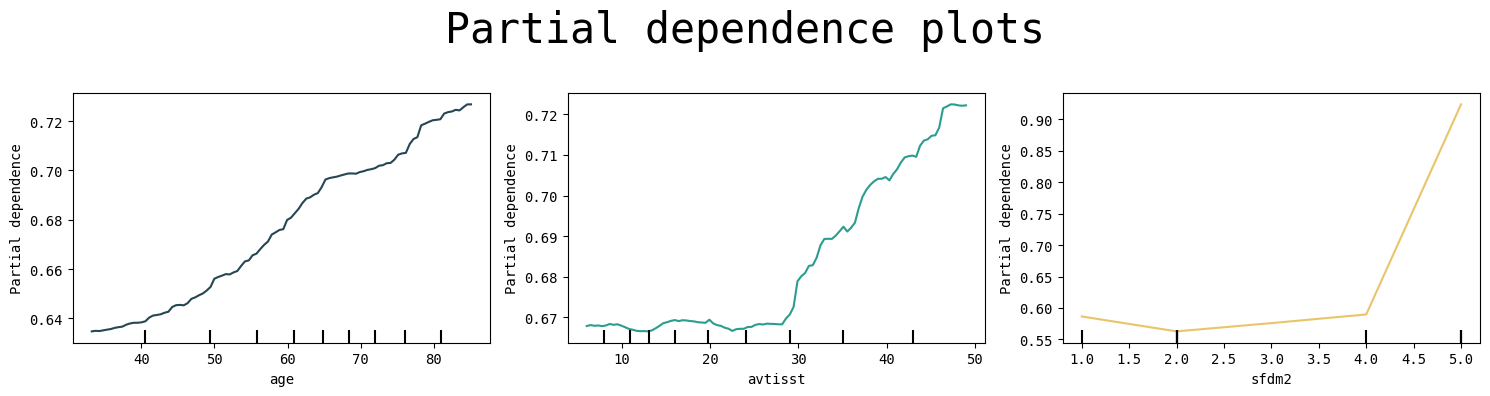

In [46]:
# filtered features with more than 5% of importance
filtered_features_5 = feature_names[importances > 0.05]
filtered_features_5 = [f.split("__")[-1] for f in filtered_features_5]

n_features = len(filtered_features_5)
n_cols = 3
n_rows = math.ceil(n_features/n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize = (5*n_cols, 4*n_rows))
axs = axs.flatten()

# For loop pver all features
for i, feature in enumerate(filtered_features_5):
    PartialDependenceDisplay.from_estimator(
        best_models['Random Forest'], 
        X_classification, 
        features = [feature], 
        ax = axs[i],
        line_kw = {'color': custom_colors[i]}
    )

for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.suptitle("Partial dependence plots", fontsize = 30)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In conclusion, the Random Forest model performs well even on test data, with little to no overfitting (AUC = 0.88). The feature with the most importance is sfdm2 which denotes the 'Level of functional disability of the patient in a 1-5 scale': when the value of sfdm2 raises over 2, the probability of dying raises, with a sharp increment when sfdm2 = 5. 

Other important features (importance > 5%) are:
- age, that shows a constant increasing probability of death;
- avtisst (Average TISS score, days 3-25, where "Therapeutic Intervention Scoring System (TISS) is a method for calculating costs in the intensive care unit (ICU) and intermediate care unit (IMCU)"). This doesn't increase the base probability of death until the 30 mark is reached: after that, the increment is constant.

Other features are necessary in the model but less important: they still help in building a strong classification model.

# 5. Clustering task
This clustering analysis aims to understand whether we can identify several degrees of severity in the patients’ conditions based on the ordinal functional disability variable 'sfdm2'.

## 5.1 Preprocessing
First I reconstructed the dataset from the beginning, eliminating the edits I've done on sfdm2 (to recall: I imputed the value of it using other variables). Including these edits would "help" the clustering, and instead the goal is to let the algorithms find patterns themselves.

In [47]:
# Processing of dataset
# I fetch the specific dataset that has id 880
support2 = fetch_ucirepo(id=880) 

# The variables to remove were already flagged in the dataset info I wrote down.
variables_to_remove = dataset_info.loc[dataset_info['from_model']==True,"name"].values

# I use the data.original because it is not divided in features and target: I want to be the one deciding what my target is.
data = support2.data.original

# I remove the columns containing the variables flagged True if they come from a model.
data_filtered = data.drop(variables_to_remove, axis = 1)

# Percent of missing values
missing_before = data_filtered.isnull().mean().sort_values(ascending=False)
print(f"Found {len(missing_before[missing_before > 0])} variables with missing data:")
print(f"\n")
print("Substituting missing values...")

# Imputing missing values with recommended ones.
recommended = {
    "alb" : 3.5,
    "pafi" : 333.3,
    "bili" : 1.01,
    "crea" : 1.01,
    "bun" : 6.51,
    "wblc" : 9.0,
    "urine" : 2502
}

data_substituted = data_filtered.copy()
for x in recommended.keys():
    for individual in range(0,len(data_substituted.index)):
        if pd.isna(data_substituted[x][individual]):
            data_substituted.loc[individual, x] = recommended[x]
            
print("Finished!")
print(f"\n")
# hecking now how many variables still have missing data.
missing = data_substituted.isnull().mean().sort_values(ascending=False)

print(f"Now only {len(missing[missing > 0])} variables have missing data.")


# Changing sfdm2 from categorical to numerical values
numerical_values  = {
    "adl>=4 (>=5 if sur)" : 1,
    "no(M2 and SIP pres)" : 2,
    "SIP>=30" : 3,
    "Coma or Intub" : 4,
    "<2 mo. follow-up" : 5
}

for individual in range(0,len(data_substituted.index)):
    SIP_value = data_substituted.loc[individual, "sfdm2"]
    if isinstance(SIP_value, str):
        data_substituted.loc[individual, "sfdm2"] = numerical_values[SIP_value]

data_substituted["sfdm2"] = data_substituted["sfdm2"].astype(float)

Found 24 variables with missing data:


Substituting missing values...
Finished!


Now only 17 variables have missing data.


Then I removed the variables id and those with more than 10% of missing data (not including sfdm2).

In [48]:
variables_to_remove = dataset_info.loc[
    (dataset_info['missing_values(%)'] >= 10) & 
    (dataset_info['from_model'] == False) & (dataset_info['name'] != "sfdm2"), 
    "name"
].values

# I remove the columns containing the variables flagged.
data_substituted = data_substituted.drop(variables_to_remove, axis = 1)
data_substituted = data_substituted.drop(columns=["id"])

# We add the imputed totcst variable
data_substituted["totcst"] = y_filled.copy()

# Since the y I added is in log, I change also the others that we observed having a logarithmic scale too
data_substituted['charges'] = np.log1p(data_substituted['charges'])
data_substituted['slos'] = np.log1p(data_substituted['slos'])
data_substituted['hday'] = np.log1p(data_substituted['hday'])

# And now I can drop rows with NA values.
print(f'Individuals before dropping NA values: {len(data_substituted)}')
data_no_na = data_substituted.dropna()
print(f'Individuals after dropping NA values: {len(data_no_na)}')

Individuals before dropping NA values: 9105
Individuals after dropping NA values: 7468


The dataset needs to be divided (we exclude the target sfdm2) and scaled.

In [49]:
X_clustering = data_no_na.drop(columns = "sfdm2")
y_clustering = data_no_na["sfdm2"]

# Transform categorical features in dummy variables 
# Numerical columns (int or float)
all_numeric = X_clustering.select_dtypes(include=['int64', 'float64'])

# Binary columns (ex: 0/1)
binary_cols = [col for col in all_numeric.columns if X_clustering[col].nunique() == 2]

# Categorical columns from the binary ones
true_numeric_cols = [col for col in all_numeric.columns if col not in binary_cols]

# True categorical columns
categorical_cols = X_clustering.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), true_numeric_cols),       # I apply scaling only on real numeric values
    ('cat', OneHotEncoder(drop='first'), categorical_cols),  # I apply one hot encoder to the categoricals
    ('bin', 'passthrough', binary_cols)                 # and I leave unchanged the binary ones
])

X_scaled_array = preprocessor.fit_transform(X_clustering)

# Reconstruct the dataframe
feature_names = preprocessor.get_feature_names_out()
X_clustering_scaled = pd.DataFrame(X_scaled_array, columns=feature_names)

## 5.2 Application of Clustering algorithms with default parameters
I first applied the following algorithms using default parameters for:
- KMeans;
- Agglomerative clustering (default linkage: ward);
- DBSCAN.

Then I visualized the data using PCA just for visualization and no dimensionality reduction.

KMeans average silhouette: 0.07
Agglomerative clustering Average silhouette: 0.1
DBSCAN failed to form more than one cluster; silhouette score not applicable.


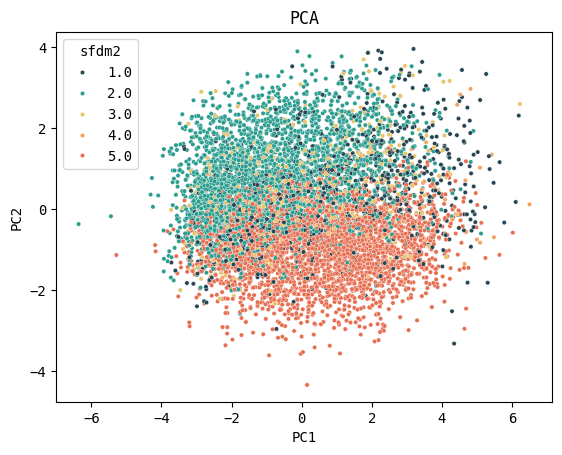

In [51]:
pca = PCA()
X_pca = pca.fit_transform(X_clustering_scaled)

# Kmeans with 2 Clusters 
kmeans = KMeans().fit(X_pca)
labels_kmeans = kmeans.labels_
print("KMeans average silhouette:", round(silhouette_score(X_pca, labels_kmeans),2))

# Agglomerative
agg = AgglomerativeClustering().fit(X_pca)
labels_agg = agg.labels_
print("Agglomerative clustering Average silhouette:", round(silhouette_score(X_pca, labels_agg),2))

# DBSCAN
dbscan = DBSCAN().fit(X_pca)
labels_db = dbscan.labels_
if len(set(labels_db)) > 1:
    print("DBSCAN Average silhouette:", round(silhouette_score(X_pca, labels_db), 2))
else:
    print("DBSCAN failed to form more than one cluster; silhouette score not applicable.")

# Visualization
sns.scatterplot(x = X_pca[:,0], y = X_pca[:,1], hue = y_clustering, palette = custom_colors, s = 10)
plt.title("PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

As before, using default parameteres doesn't yield good results.

## 5.3 Hyperparameters tuning
Each clustering method (aside from DBSCAN) requires a previous choice of K: I could've used K = 5 as the number of classes in sfdm2, but the goal is to lead **unsupervised** learning.
### 5.3.1 Dimensionality reduction with PCA
I decided to reduce dimensionality of the data using PCA to reduce the noise, and, in doing so, hopefully individuate better clusters.

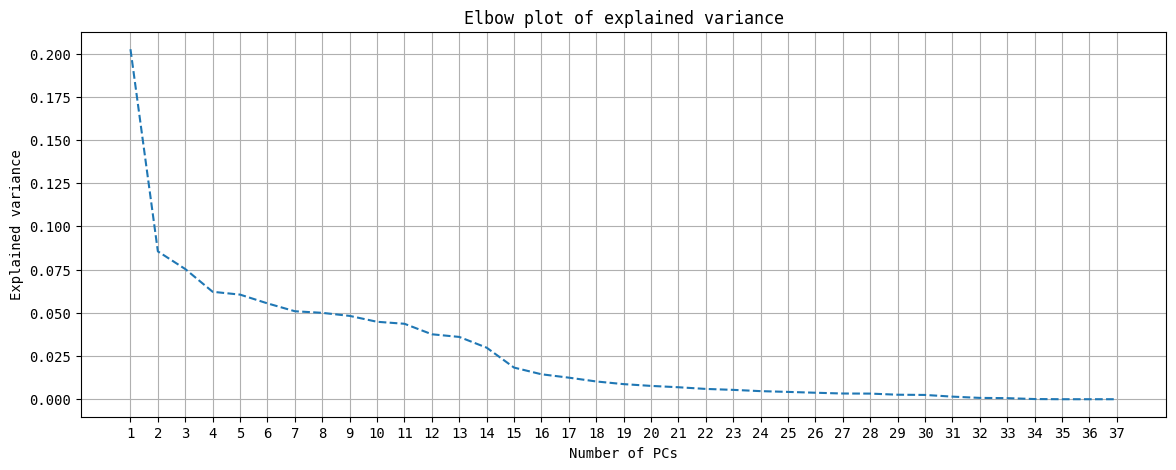

In [52]:
# First call PCA on the scaled data
pca = PCA()
pca.fit(X_clustering_scaled)

# I obtain the explained variance of every Principal Component
explained_variance = pca.explained_variance_ratio_

# Elbow plot
plt.figure(figsize=(14,5))
plt.plot(range(1, len(explained_variance)+1), explained_variance, linestyle='--')
plt.xlabel('Number of PCs')
plt.ylabel('Explained variance')
plt.title('Elbow plot of explained variance')
plt.xticks(range(1, len(explained_variance)+1))
plt.grid(True)
plt.show()

After 8 PCs the explained variance decreases under 5%: by noticing that the following results don't improve if I select more than 8 PCs (they actually worsen), I settled with this amount of principal components.

In [53]:
pca = PCA(n_components = 8)
X_pca = pca.fit_transform(X_clustering_scaled)

#### Choosing numbers of K and values of eps
To help with the evaluation and visualization, I defined some supporting functions.
I decided to evaluate each clustering method using two types of indexes:
- **Silhouette score.** This is a type of Internal metric that is used to measure the goodness of a clustering structure without external information. It combines both the idea of cohesion and separation, and can give an idea of how much elements from the same cluster are close to each other, and far from elements of different clusters. For each point, silhouette is computed as:
\begin{equation}
  s =\begin{cases}
    1 - \frac{a}{b}, & \text{if $a<b$}.\\
    \frac{b}{a} - 1, & \text{otherwise}.
  \end{cases}
\end{equation}
where 
    - a = average distance of a point from the other points in the same cluster, 
    - b = minimum of the average distance of a point from the points in another cluster.
- **Adjusted Rand Index.** This is a type of External matrix that is used to measure the extent to which clusters' labels match externally supplied class labels (in out case, the true sfdm2 labels). The Rand Index  computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings. The raw RI score is then “adjusted for chance” into the ARI score using the following scheme:

$$
ARI = (RI - Expected\_RI) / (max(RI) - Expected\_RI)
$$

The adjusted Rand index is thus ensured to have a value close to 0.0 for random labeling independently of the number of clusters and samples and exactly 1.0 when the clusterings are identical (up to a permutation). 
(Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.)


I decided to use this type of scoring since it's already implemented in scikit-learn and, differently from Jaccard similarity, doesn't neglect true negatives (observations with different labels are included in different clusters) which I thought would be informative of the quality of the clustering used.

In [54]:
# Supporting functions
def evaluate_clustering(X, labels, true_labels = None):
    """
    Evaluates clustering applying metrics for the clustering evaluation: silhouette coefficient for the separation 
    of clusters and ARI (Adjusted Rand scores) if the correct labels are provided.

    Input:
    - X (variables);
    - labels (predicted labels);
    - true_labels, default = None (predicted labels).

    Output:
    A tuple containing the Silhouette coefficient and the ARI.
    """
    unique_labels = np.unique(labels)

    if len(unique_labels) <= 1:
        # Case in which only one cluster is found, a silhouette score cannot be computed.
        silhouette = -1
    else:
        silhouette = silhouette_score(X, labels)
    
    if true_labels is not None:
        ari = adjusted_rand_score(true_labels, labels)
    else:
        # If no true_labels are provided, ARI cannot be computed.
        ari = None
    
    return silhouette, ari


def plot_all_clusterings(X_pca, clusterings, true_labels, titles, cols = 2):
    """
    Function to plot different clustering algorithms one beside the other (good for comparison).

    Input:
    - X_pca (variables, already scaled and dimensionally reduced using PCA);
    - clusterings (list containing all the predicted labels from different clustering algorithms);
    - true_labels (true labels);
    - titles (titles to assign to each graph);
    - cols, default = 2 (columns in which to order the graphs).

    Output:
    - prints the plot.
    """
    # Number of plots 
    n_plots = len(clusterings)
    rows = (n_plots + cols - 1)//cols
    plt.figure(figsize=(cols*6, rows*5))
    

    # zip couples clustering model and labels together
    for i, (labels, title) in enumerate(zip(clusterings, titles), 1):
        if len(set(labels)) <= 5:
            palette = custom_colors
        else:
            palette = 'plasma'

        plt.subplot(rows, cols, i)
        sns.scatterplot(x = X_pca[:,0], y = X_pca[:,1], hue = labels, palette = palette, s = 15)
        plt.title(title, fontsize=18)
        plt.legend(title = "Cluster", loc = 'best')
        
    # Also prints the graph with the true colors once
    plt.subplot(rows, cols, n_plots + 1)
    sns.scatterplot(x = X_pca[:,0], y=X_pca[:,1], hue = true_labels, palette = custom_colors, s = 15)
    plt.title("True Labels", fontsize = 18)
    plt.legend(title="True Labels", loc = 'best')
    
    plt.tight_layout()
    plt.show()

I then explored different values of K and eps for the following clustering methods:
- KMeans;
- Agglomerative clustering (with ward*, complete, average and single linkage);
- DBSCAN;
- GMM (Gaussian mixture models).

*Ward’s is the only one among the agglomerative clustering methods
that is based on a classical sum-of-squares criterion, producing groups that
minimize within-group dispersion at each binary fusion.

Since I noticed that it is difficult to divide our observations in definite clusters and the silhouette scores are always generally bad, I decided to plot how much the ARI score improves depending on K (instead of the silhouette score), and the BIC score for GMM, and select the optimal K depending on that.

1) Evaluating KMeans Clustering...
Best k for Kmeans, by ARI: 3
2) Evaluating agglomerative Clustering...
Best k for linkage 'ward', by ARI: 7
Best k for linkage 'complete', by ARI: 15
Best k for linkage 'average', by ARI: 2
Best k for linkage 'single', by ARI: 19
3) Evaluating DBSCAN...
Best value for eps, by ARI: 1.3
4) Evaluatig GMM (Expectation Maximization)...
Best value for GMM, by BIC: 6


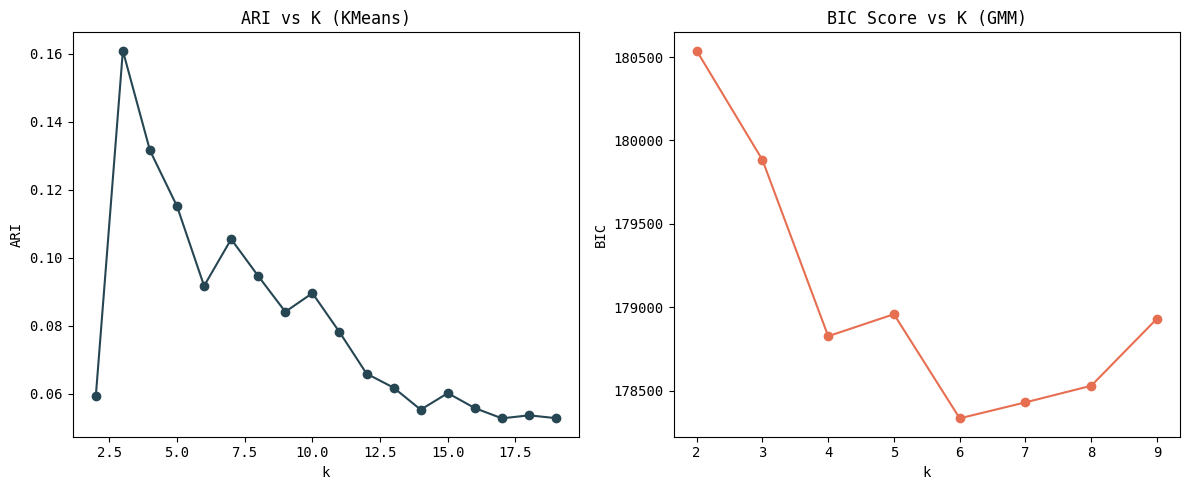

C:\Users\flavi\AppData\Local\Temp\ipykernel_20344\893729753.py:60: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.scatterplot(x = X_pca[:,0], y = X_pca[:,1], hue = labels, palette = palette, s = 15)
C:\Users\flavi\AppData\Local\Temp\ipykernel_20344\893729753.py:60: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.scatterplot(x = X_pca[:,0], y = X_pca[:,1], hue = labels, palette = palette, s = 15)
C:\Users\flavi\AppData\Local\Temp\ipykernel_20344\893729753.py:60: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.scatterplot(x = X_pca[:,0], y = X_pca[:,1], hue = labels, palette = palette, s = 15)


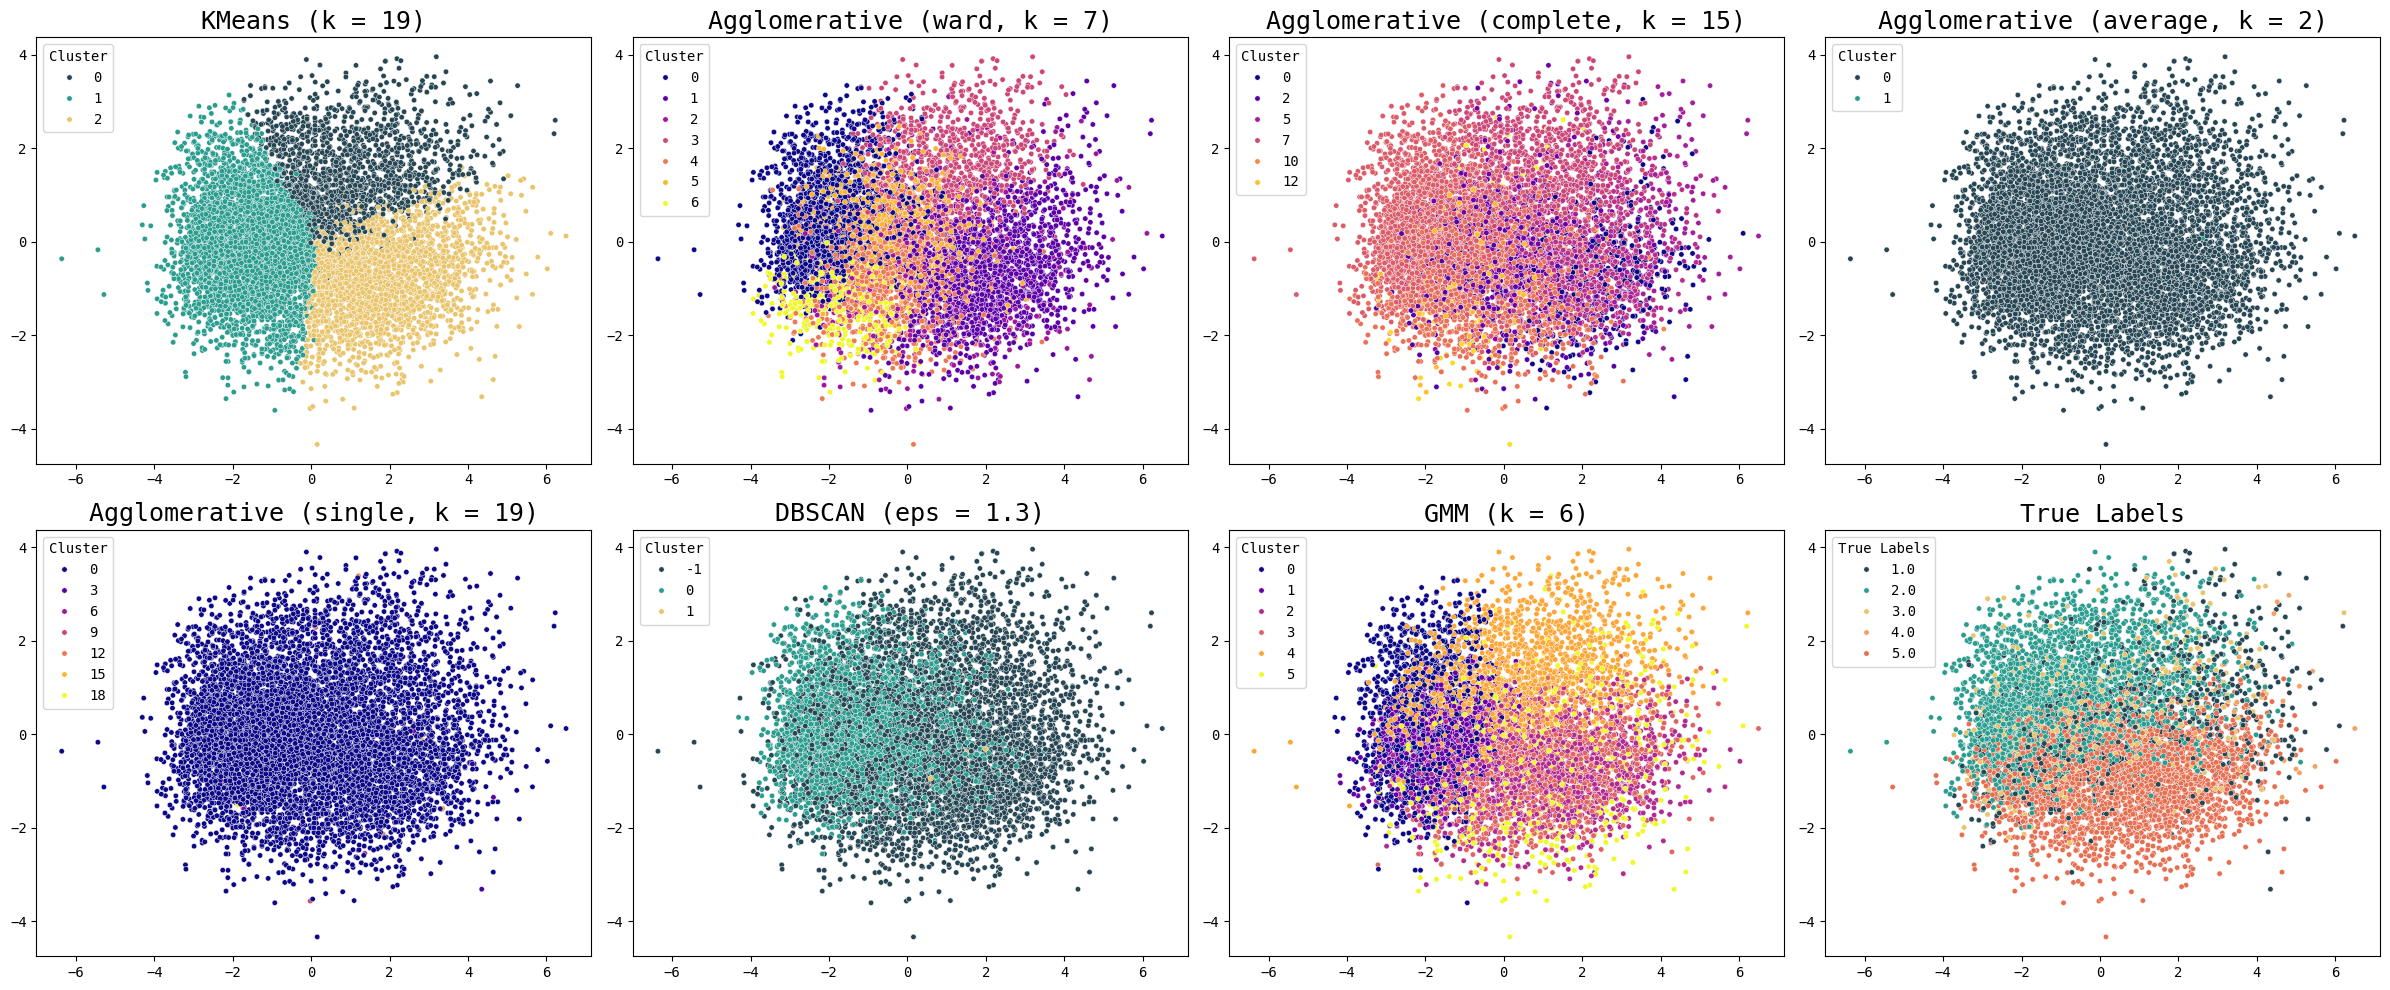

In [55]:
####################################### Evaluation of K-means ##########################################
print("1) Evaluating KMeans Clustering...")
aris = []
for k in range(2, 20):
    km = KMeans(n_clusters = k, random_state = 19)
    labels = km.fit_predict(X_pca)
    s, a = evaluate_clustering(X_pca, labels, y_clustering)
    aris.append(a)

best_kmeans = np.argmax(aris) + 2
print(f"Best k for Kmeans, by ARI: {best_kmeans}")
kmeans_final = KMeans(n_clusters = best_kmeans, random_state = 19).fit(X_pca)

####################################### Evaluation of agglomerative clustering ##########################
print("2) Evaluating agglomerative Clustering...")
linkages = ['ward', 'complete', 'average', 'single']
agglom_labels = []
agglom_titles = []

for linkage in linkages:
    best_ari = -1
    best_k = None
    best_labels = None
    
    for k in range(2, 20):
        model = AgglomerativeClustering(n_clusters = k, linkage = linkage)
        labels = model.fit_predict(X_pca)
        s, ari = evaluate_clustering(X_pca, labels, y_clustering)
            
        if ari > best_ari:
            best_ari = ari
            best_k = k
            best_labels = labels
    
    agglom_labels.append(best_labels)
    agglom_titles.append(f"Agglomerative ({linkage}, k = {best_k})")
    print(f"Best k for linkage '{linkage}', by ARI: {best_k}")
    
####################################### Evaluation of DBSCAN  ###############################
print("3) Evaluating DBSCAN...")
eps_values = [0.3, 0.5, 0.7, 1.0, 1.3, 1.5, 2.0]
best_score = -1
best_eps = None
best_labels = None

for eps in eps_values:
    db = DBSCAN(eps = eps, min_samples = 15)
    labels = db.fit_predict(X_pca)
    s, ari = evaluate_clustering(X_pca, labels, y_clustering)
    
    if ari > best_score:
        best_score = ari
        best_eps = eps
        best_labels = labels

print(f"Best value for eps, by ARI: {best_eps}")

####################################### Evaluation of GMM  ####################################
print("4) Evaluatig GMM (Expectation Maximization)...")
bic_scores = []
for k in range(2, 10):
    gmm = GaussianMixture(n_components = k, random_state = 19)
    gmm.fit(X_pca)
    bic_scores.append(gmm.bic(X_pca))

best_k_gmm = np.argmin(bic_scores) + 2
gmm_final = GaussianMixture(n_components =  best_k_gmm, random_state = 19).fit(X_pca)
labels_gmm = gmm_final.predict(X_pca)

print(f"Best value for GMM, by BIC: {best_k_gmm}")


################################################## Plots ######################################
plt.figure(figsize=(12, 5))

# ARI scores Kmeans (an example of how the comparison of ARI works)
plt.subplot(1, 2, 1)
plt.plot(range(2, 20), aris, marker='o', color = custom_colors[0])
plt.title("ARI vs K (KMeans)")
plt.xlabel("k")
plt.ylabel("ARI")

# BIC (GMM)
plt.subplot(1, 2, 2)
plt.plot(range(2, 10), bic_scores, marker='o', color = custom_colors[4])
plt.title("BIC Score vs K (GMM)")
plt.xlabel("k")
plt.ylabel("BIC")

plt.tight_layout()
plt.show()


# Finak plots with labels
all_clusterings = [kmeans_final.labels_] + agglom_labels
all_clusterings.append(best_labels)
all_clusterings.append(labels_gmm)

all_titles = [f"KMeans (k = {best_k})"] + agglom_titles
all_titles.append(f"DBSCAN (eps = {best_eps})")
all_titles.append(f"GMM (k = {best_k_gmm})")

plot_all_clusterings(X_pca, all_clusterings, y_clustering, all_titles, cols = 4)

#### Summary of the results using PCA dimensionality reduction (8 PCs)

In [56]:
results = []

# KMeans
ari_kmeans = adjusted_rand_score(y_clustering, kmeans_final.labels_)
results.append({
    'Method': 'KMeans',
    'Parameter': f'k = {best_k}',
    'ARI': ari_kmeans
})

# Agglomerative
for linkage, labels in zip(linkages, agglom_labels):
    ari = adjusted_rand_score(y_clustering, labels)
    results.append({
        'Method': 'Agglomerative',
        'Parameter': f'linkage = {linkage}',
        'ARI': ari
    })

# DBSCAN
ari_dbscan = adjusted_rand_score(y_clustering, best_labels)
results.append({
        'Method': 'DBSCAN',
        'Parameter': f'eps = {best_eps}',
        'ARI': ari_dbscan
    })

# GMM
ari_gmm = adjusted_rand_score(y_clustering, labels_gmm)
results.append({
    'Method': 'GMM',
    'Parameter': f'k = {best_k_gmm}',
    'ARI': ari_gmm
})

# Sort dataframe by ARI
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by = 'ARI', ascending = False).reset_index(drop = True)

print("Results, using ARI as comparison")
print(f'\f')
print(df_results)
print(f'\n')
print(f"Best method, by ARI: {df_results.iloc[0]["Method"]}")

Results, using ARI as comparison

          Method           Parameter       ARI
0         KMeans              k = 19  0.160915
1            GMM               k = 6  0.153455
2  Agglomerative      linkage = ward  0.127293
3  Agglomerative  linkage = complete  0.085937
4         DBSCAN           eps = 1.3  0.030437
5  Agglomerative    linkage = single  0.000405
6  Agglomerative   linkage = average  0.000217


Best method, by ARI: KMeans


### 5.3.1 Dimensionality reduction with UMAP
There are different methods that can be used for dimensionality reduction: one of these is UMAP. Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction (umap documentation). I kept the same number of PCs, but reduced dimensionality using UMAP instead of PCA. 

C:\Users\flavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


1) Evaluating KMeans Clustering...
Best k for Kmeans, by ARI: 4
2) Evaluating agglomerative Clustering...
Best k for linkage 'ward', by ARI: 4
Best k for linkage 'complete', by ARI: 9
Best k for linkage 'average', by ARI: 7
Best k for linkage 'single', by ARI: 4
3) Evaluating DBSCAN...
Best value for eps, by ARI: 0.3
4) Evaluatig GMM (Expectation Maximization)...
Best value for GMM, by BIC: 9


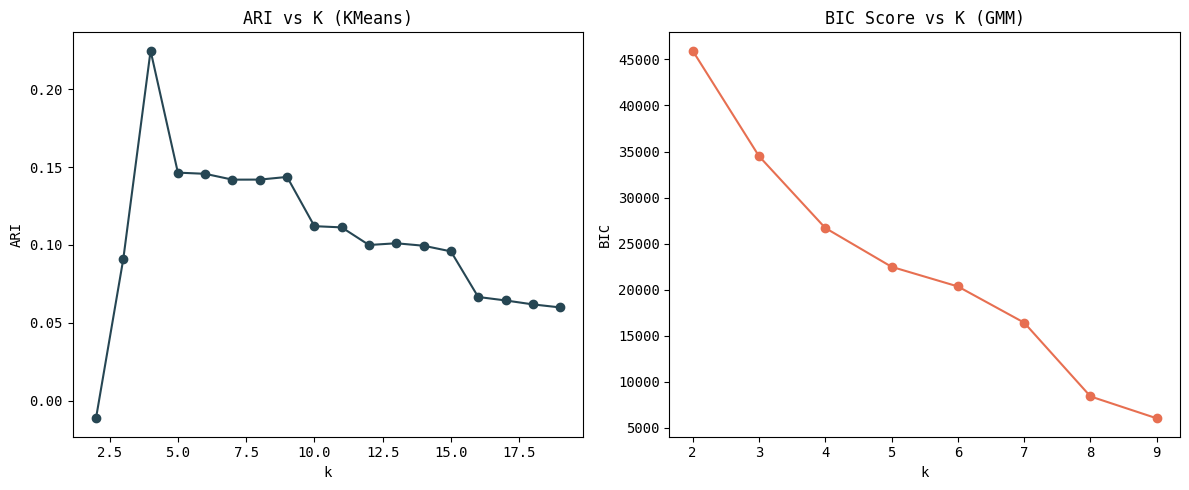

C:\Users\flavi\AppData\Local\Temp\ipykernel_20344\893729753.py:60: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.scatterplot(x = X_pca[:,0], y = X_pca[:,1], hue = labels, palette = palette, s = 15)
C:\Users\flavi\AppData\Local\Temp\ipykernel_20344\893729753.py:60: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.scatterplot(x = X_pca[:,0], y = X_pca[:,1], hue = labels, palette = palette, s = 15)
C:\Users\flavi\AppData\Local\Temp\ipykernel_20344\893729753.py:60: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.scatterplot(x = X_pca[:,0], y = X_pca[:,1], hue = labels, palette = palette, s = 15)


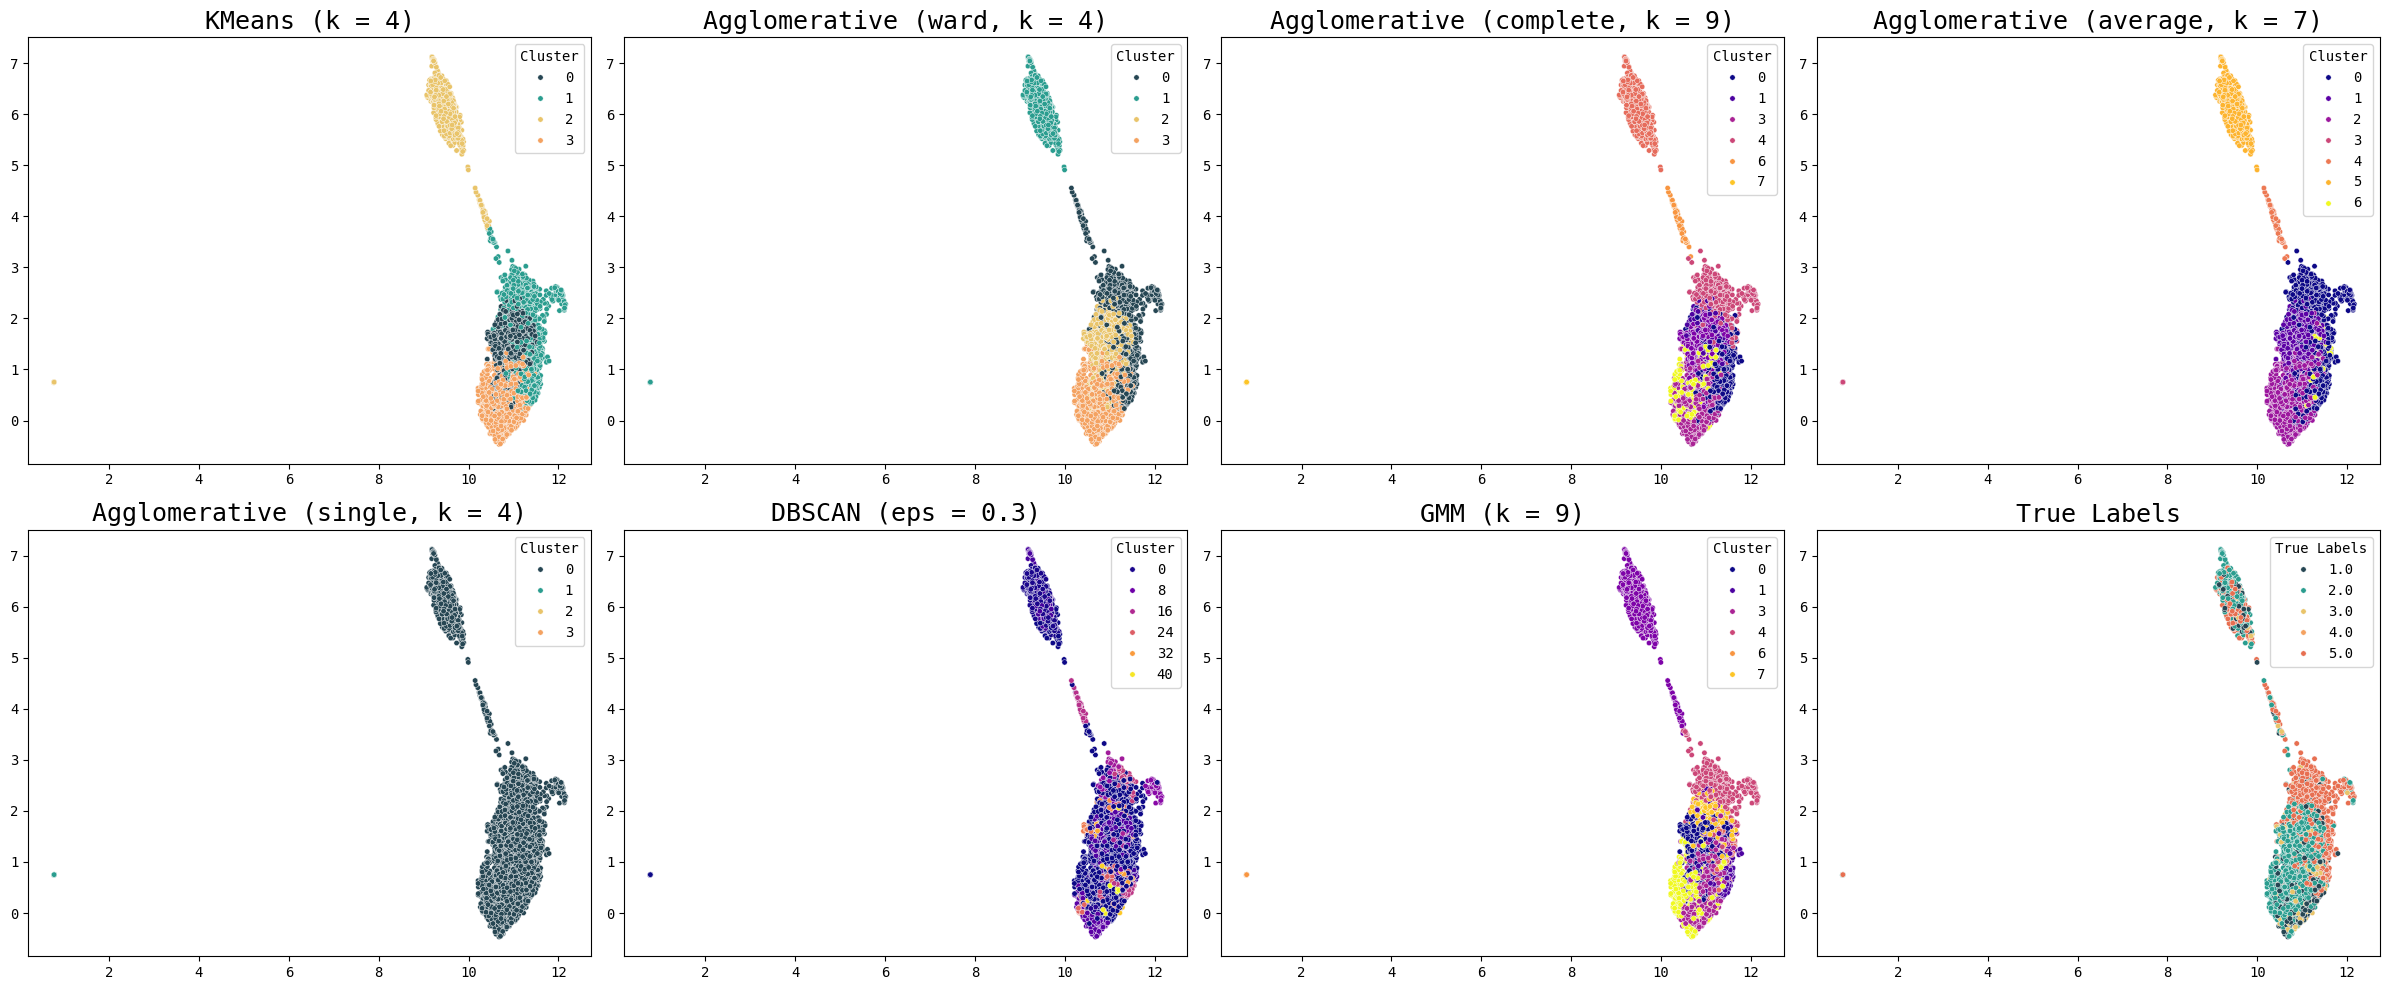

In [57]:
reducer = umap.UMAP(n_components = 8, random_state = 3)
X_umap = reducer.fit_transform(X_clustering_scaled)

####################################### Evaluation of K-means ##########################################
print("1) Evaluating KMeans Clustering...")
aris = []
for k in range(2, 20):
    km = KMeans(n_clusters = k, random_state = 19)
    labels = km.fit_predict(X_umap)
    s, a = evaluate_clustering(X_umap, labels, y_clustering)
    aris.append(a)

best_kmeans = np.argmax(aris) + 2
print(f"Best k for Kmeans, by ARI: {best_kmeans}")
kmeans_final = KMeans(n_clusters = best_kmeans, random_state = 19).fit(X_umap)

####################################### Evaluation of agglomerative clustering ##########################
print("2) Evaluating agglomerative Clustering...")
linkages = ['ward', 'complete', 'average', 'single']
agglom_labels = []
agglom_titles = []

for linkage in linkages:
    best_ari = -1
    best_k = None
    best_labels = None
    
    for k in range(2, 20):
        model = AgglomerativeClustering(n_clusters = k, linkage = linkage)
        labels = model.fit_predict(X_umap)
        s, ari = evaluate_clustering(X_umap, labels, y_clustering)
            
        if ari > best_ari:
            best_ari = ari
            best_k = k
            best_labels = labels
    
    agglom_labels.append(best_labels)
    agglom_titles.append(f"Agglomerative ({linkage}, k = {best_k})")
    print(f"Best k for linkage '{linkage}', by ARI: {best_k}")
    
####################################### Evaluation of DBSCAN  ###############################
print("3) Evaluating DBSCAN...")
eps_values = [0.3, 0.5, 0.7, 1.0, 1.3, 1.5, 2.0]
best_score = -1
best_eps = None
best_labels = None

for eps in eps_values:
    db = DBSCAN(eps = eps, min_samples = 15)
    labels = db.fit_predict(X_umap)
    s, ari = evaluate_clustering(X_umap, labels, y_clustering)
    
    if ari > best_score:
        best_score = ari
        best_eps = eps
        best_labels = labels

print(f"Best value for eps, by ARI: {best_eps}")

####################################### Evaluation of GMM  ####################################
print("4) Evaluatig GMM (Expectation Maximization)...")
bic_scores = []
for k in range(2, 10):
    gmm = GaussianMixture(n_components = k, random_state = 19)
    gmm.fit(X_umap)
    bic_scores.append(gmm.bic(X_umap))

best_k_gmm = np.argmin(bic_scores) + 2
gmm_final = GaussianMixture(n_components =  best_k_gmm, random_state = 19).fit(X_umap)
labels_gmm = gmm_final.predict(X_umap)

print(f"Best value for GMM, by BIC: {best_k_gmm}")




################################################## Plots ######################################
plt.figure(figsize=(12, 5))

# ARI scores Kmeans (an example of how the comparison of ARI works)
plt.subplot(1, 2, 1)
plt.plot(range(2, 20), aris, marker='o', color = custom_colors[0])
plt.title("ARI vs K (KMeans)")
plt.xlabel("k")
plt.ylabel("ARI")

# BIC (GMM)
plt.subplot(1, 2, 2)
plt.plot(range(2, 10), bic_scores, marker='o', color = custom_colors[4])
plt.title("BIC Score vs K (GMM)")
plt.xlabel("k")
plt.ylabel("BIC")

plt.tight_layout()
plt.show()


# Finak plots with labels
all_clusterings = [kmeans_final.labels_] + agglom_labels
all_clusterings.append(best_labels)
all_clusterings.append(labels_gmm)

all_titles = [f"KMeans (k = {best_k})"] + agglom_titles
all_titles.append(f"DBSCAN (eps = {best_eps})")
all_titles.append(f"GMM (k = {best_k_gmm})")

plot_all_clusterings(X_umap, all_clusterings, y_clustering, all_titles, cols = 4)

I noticed the values of sfdm2 were still not divided in different clusters, but the visualization was slightly better.

In [58]:
results = []

# KMeans
ari_kmeans = adjusted_rand_score(y_clustering, kmeans_final.labels_)
results.append({
    'Method': 'KMeans',
    'Parameter': f'k = {best_k}',
    'ARI': ari_kmeans
})

# Agglomerative
for linkage, labels in zip(linkages, agglom_labels):
    ari = adjusted_rand_score(y_clustering, labels)
    results.append({
        'Method': 'Agglomerative',
        'Parameter': f'linkage = {linkage}',
        'ARI': ari
    })

# DBSCAN
ari_dbscan = adjusted_rand_score(y_clustering, best_labels)
results.append({
        'Method': 'DBSCAN',
        'Parameter': f'eps = {best_eps}',
        'ARI': ari_dbscan
    })

# GMM
ari_gmm = adjusted_rand_score(y_clustering, labels_gmm)
results.append({
    'Method': 'GMM',
    'Parameter': f'k = {best_k_gmm}',
    'ARI': ari_gmm
})

# Sort dataframe by ARI
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by = 'ARI', ascending = False).reset_index(drop = True)

print("Results, using ARI as comparison")
print(f'\f')
print(df_results)
print(f'\n')
print(f"Best method, by ARI: {df_results.iloc[0]["Method"]}")

Results, using ARI as comparison

          Method           Parameter       ARI
0         KMeans               k = 4  0.224706
1  Agglomerative      linkage = ward  0.209354
2  Agglomerative   linkage = average  0.190950
3  Agglomerative  linkage = complete  0.126620
4            GMM               k = 9  0.085350
5         DBSCAN           eps = 0.3  0.003269
6  Agglomerative    linkage = single  0.000257


Best method, by ARI: KMeans


The ARI score is just slightly better for every method, but nowhere near an optimal measure. Random labelings have an ARI close to 0.0, so a score of 0.20 is not considered a good one. 1.0 stands for perfect match and none of the methods got close to it.

## 5.4 Hybrid supervised and unsupervised learning
A method I took into consideration, although it doesn't exaclty answer the question we've posed, is to use an hybrid approach. The idea behind it is to build a clustering model using **only** the variables that are mostly correlated to the target value, in order to reduce the noise between clusters. Of course, this method required me to personally select the variables to involve in the construction of the model: this way the algorithm isn't properly exploring the pattern of all of the data by itself, and thus cannot be called **unsupervised** learning.

In [59]:
# Processing of dataset
# I fetch the specific dataset that has id 880
support2 = fetch_ucirepo(id=880) 

# The variables to remove were already flagged in the dataset info I wrote down.
variables_to_remove = dataset_info.loc[dataset_info['from_model']==True,"name"].values

# I use the data.original because it is not divided in features and target: I want to be the one deciding what my target is.
data = support2.data.original

# I remove the columns containing the variables flagged True if they come from a model.
data_filtered = data.drop(variables_to_remove, axis = 1)

# Percent of missing values
missing_before = data_filtered.isnull().mean().sort_values(ascending=False)
print(f"Found {len(missing_before[missing_before > 0])} variables with missing data:")
print(f"\n")
print("Substituting missing values...")

# Imputing missing values with recommended ones.
recommended = {
    "alb" : 3.5,
    "pafi" : 333.3,
    "bili" : 1.01,
    "crea" : 1.01,
    "bun" : 6.51,
    "wblc" : 9.0,
    "urine" : 2502
}

data_substituted = data_filtered.copy()
for x in recommended.keys():
    for individual in range(0,len(data_substituted.index)):
        if pd.isna(data_substituted[x][individual]):
            data_substituted.loc[individual, x] = recommended[x]
            
print("Finished!")
print(f"\n")
# hecking now how many variables still have missing data.
missing = data_substituted.isnull().mean().sort_values(ascending=False)

print(f"Now only {len(missing[missing > 0])} variables have missing data.")


# Changing sfdm2 from categorical to numerical values
numerical_values  = {
    "adl>=4 (>=5 if sur)" : 1,
    "no(M2 and SIP pres)" : 2,
    "SIP>=30" : 3,
    "Coma or Intub" : 4,
    "<2 mo. follow-up" : 5
}

for individual in range(0,len(data_substituted.index)):
    SIP_value = data_substituted.loc[individual, "sfdm2"]
    if isinstance(SIP_value, str):
        data_substituted.loc[individual, "sfdm2"] = numerical_values[SIP_value]

data_substituted["sfdm2"] = data_substituted["sfdm2"].astype(float)


variables_to_remove = dataset_info.loc[
    (dataset_info['missing_values(%)'] >= 10) & 
    (dataset_info['from_model'] == False) & (dataset_info['name'] != "sfdm2"), 
    "name"
].values

# I remove the columns containing the variables flagged.
data_substituted = data_substituted.drop(variables_to_remove, axis = 1)
data_substituted = data_substituted.drop(columns=["id"])

# We add the imputed totcst variable
data_substituted["totcst"] = y_filled.copy()

# Since the y I added is in log, I change also the others that we observed having a logarithmic scale too
data_substituted['charges'] = np.log1p(data_substituted['charges'])
data_substituted['slos'] = np.log1p(data_substituted['slos'])
data_substituted['hday'] = np.log1p(data_substituted['hday'])

Found 24 variables with missing data:


Substituting missing values...
Finished!


Now only 17 variables have missing data.


This time, before proceeding with the scaling of data, I first check which variables are correlated in any way (| r | > 0.10) to 'sfdm2'.

In [60]:
variabile_target = 'sfdm2'

# We compute correlation with numerical variables
correlazioni = data_substituted.corr(numeric_only=True)[variabile_target]

# We consider "correlated" those with |r| > 0.10 (they're not really correlated, but they surely show more of a relation)
correlate = correlazioni[correlazioni.abs() > 0.1]
nomi_variabili_correlate = correlate.index.tolist()

print(f"Numerical variables related to '{variabile_target}' (|r| > 0.10):")
print(correlate.sort_values(ascending=False))

Numerical variables related to 'sfdm2' (|r| > 0.10):
sfdm2       1.000000
hospdead    0.720117
death       0.504696
avtisst     0.357728
hday        0.182976
adlsc       0.165289
charges     0.135239
totcst      0.104442
slos       -0.167048
d.time     -0.593684
Name: sfdm2, dtype: float64


In [61]:
# If we manipulate the dataset and remove also the columns we know are not correlated to sfd2m....
data_substituted_2 = data_substituted[nomi_variabili_correlate]

# ... I can drop rows with NA values.
print(f'Individuals before dropping NA values: {len(data_substituted)}')
data_no_na = data_substituted_2.dropna()
print(f'Individuals after dropping NA values: {len(data_no_na)}')

# Then I preprocess the dataset as I've already done before.
X_clustering = data_no_na.drop(columns = "sfdm2")
y_clustering = data_no_na["sfdm2"]

# Numerical columns (int or float)
all_numeric = X_clustering.select_dtypes(include=['int64', 'float64'])

# Binary columns (ex: 0/1)
binary_cols = [col for col in all_numeric.columns if X_clustering[col].nunique() == 2]

# Categorical columns from the binary ones
true_numeric_cols = [col for col in all_numeric.columns if col not in binary_cols]

# True categorical columns
categorical_cols = X_clustering.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), true_numeric_cols),       # I apply scaling only on real numeric values
    ('cat', OneHotEncoder(drop='first'), categorical_cols),  # I apply one hot encoder to the categoricals
    ('bin', 'passthrough', binary_cols)                 # and I leave unchanged the binary ones
])

X_scaled_array = preprocessor.fit_transform(X_clustering)

# Reconstruct the dataframe
feature_names = preprocessor.get_feature_names_out()
X_clustering_scaled = pd.DataFrame(X_scaled_array, columns=feature_names)


Individuals before dropping NA values: 9105
Individuals after dropping NA values: 7498


### 5.4.2 Dimensionality reduction
As before I applied PCA dimensionality reduction: because we have less parameters there's less of a choice for the number of principal components. Nevertheless, I've noticed that following this method the first PCs have an higher value of PVE (Proportion of Variance Explained), defined as:

$$
PVE_k = \frac{Var(Z_k)}{\sum_{j=1}^p Var(X_j)} 
$$

in comparison to before personally selecting the variables.

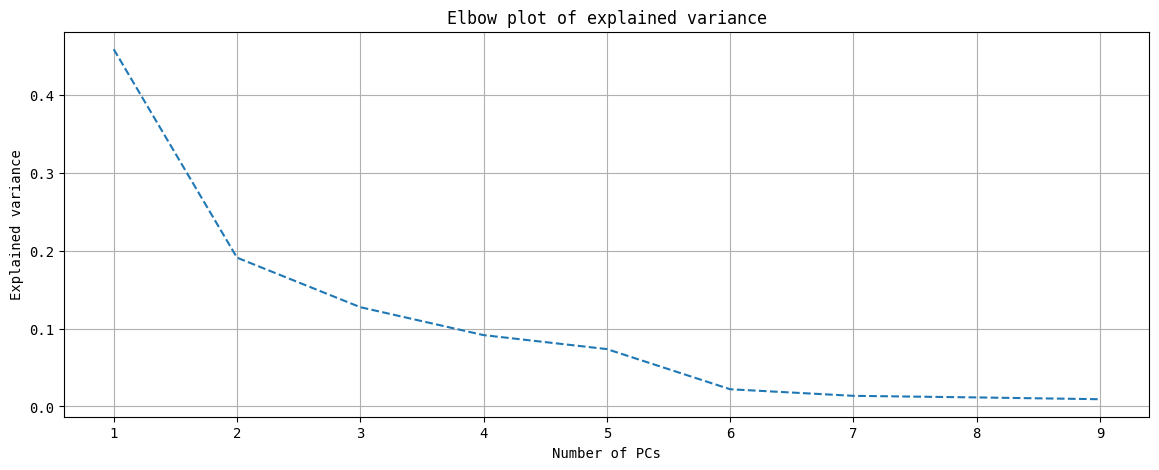

In [62]:
# First call PCA on the scaled data
pca = PCA()
pca.fit(X_clustering_scaled)

# I obtain the explained variance of every Principal Component
explained_variance = pca.explained_variance_ratio_

# Elbow plot
plt.figure(figsize=(14,5))
plt.plot(range(1, len(explained_variance)+1), explained_variance, linestyle='--')
plt.xlabel('Number of PCs')
plt.ylabel('Explained variance')
plt.title('Elbow plot of explained variance')
plt.xticks(range(1, len(explained_variance)+1))
plt.grid(True)
plt.show()

#### Results using UMAP (3 PCs)
I decided to skip dimensionality reduction using PCA for visualization, and instead proceeded with UMAP dimensionality reduction using the first three PCs. This is because they cumulatively explain already more than 75% of the variance of the data: including the others might include noise in the model.

C:\Users\flavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


1) Evaluating KMeans Clustering...
Best k for Kmeans, by ARI: 6
2) Evaluating agglomerative Clustering...
Best k for linkage 'ward', by ARI: 4
Best k for linkage 'complete', by ARI: 5
Best k for linkage 'average', by ARI: 5
Best k for linkage 'single', by ARI: 5
3) Evaluating DBSCAN...
Best value for eps, by ARI: 0.5
4) Evaluatig GMM (Expectation Maximization)...
Best value for GMM, by BIC: 9


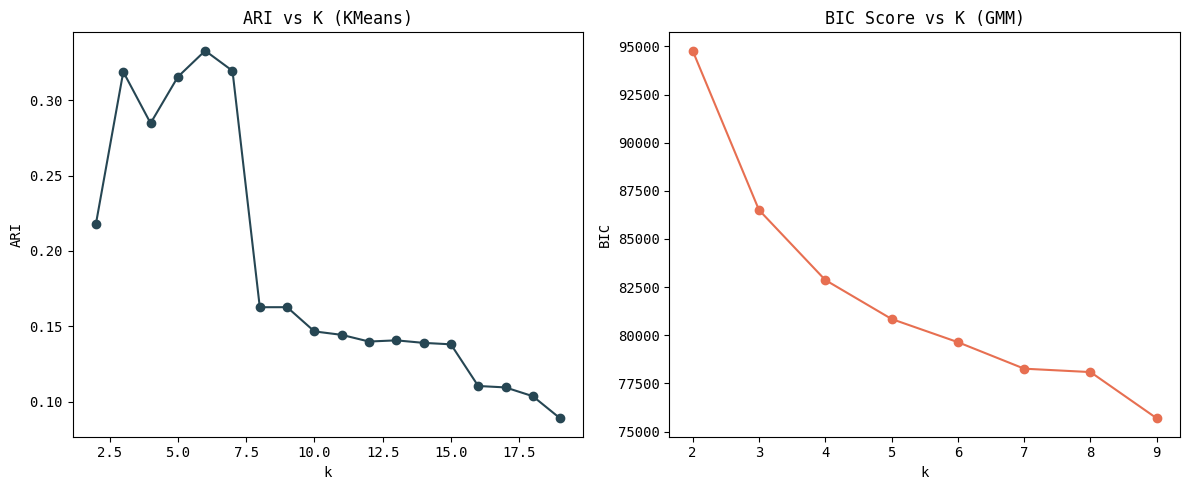

C:\Users\flavi\AppData\Local\Temp\ipykernel_20344\893729753.py:60: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.scatterplot(x = X_pca[:,0], y = X_pca[:,1], hue = labels, palette = palette, s = 15)
C:\Users\flavi\AppData\Local\Temp\ipykernel_20344\893729753.py:60: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.scatterplot(x = X_pca[:,0], y = X_pca[:,1], hue = labels, palette = palette, s = 15)


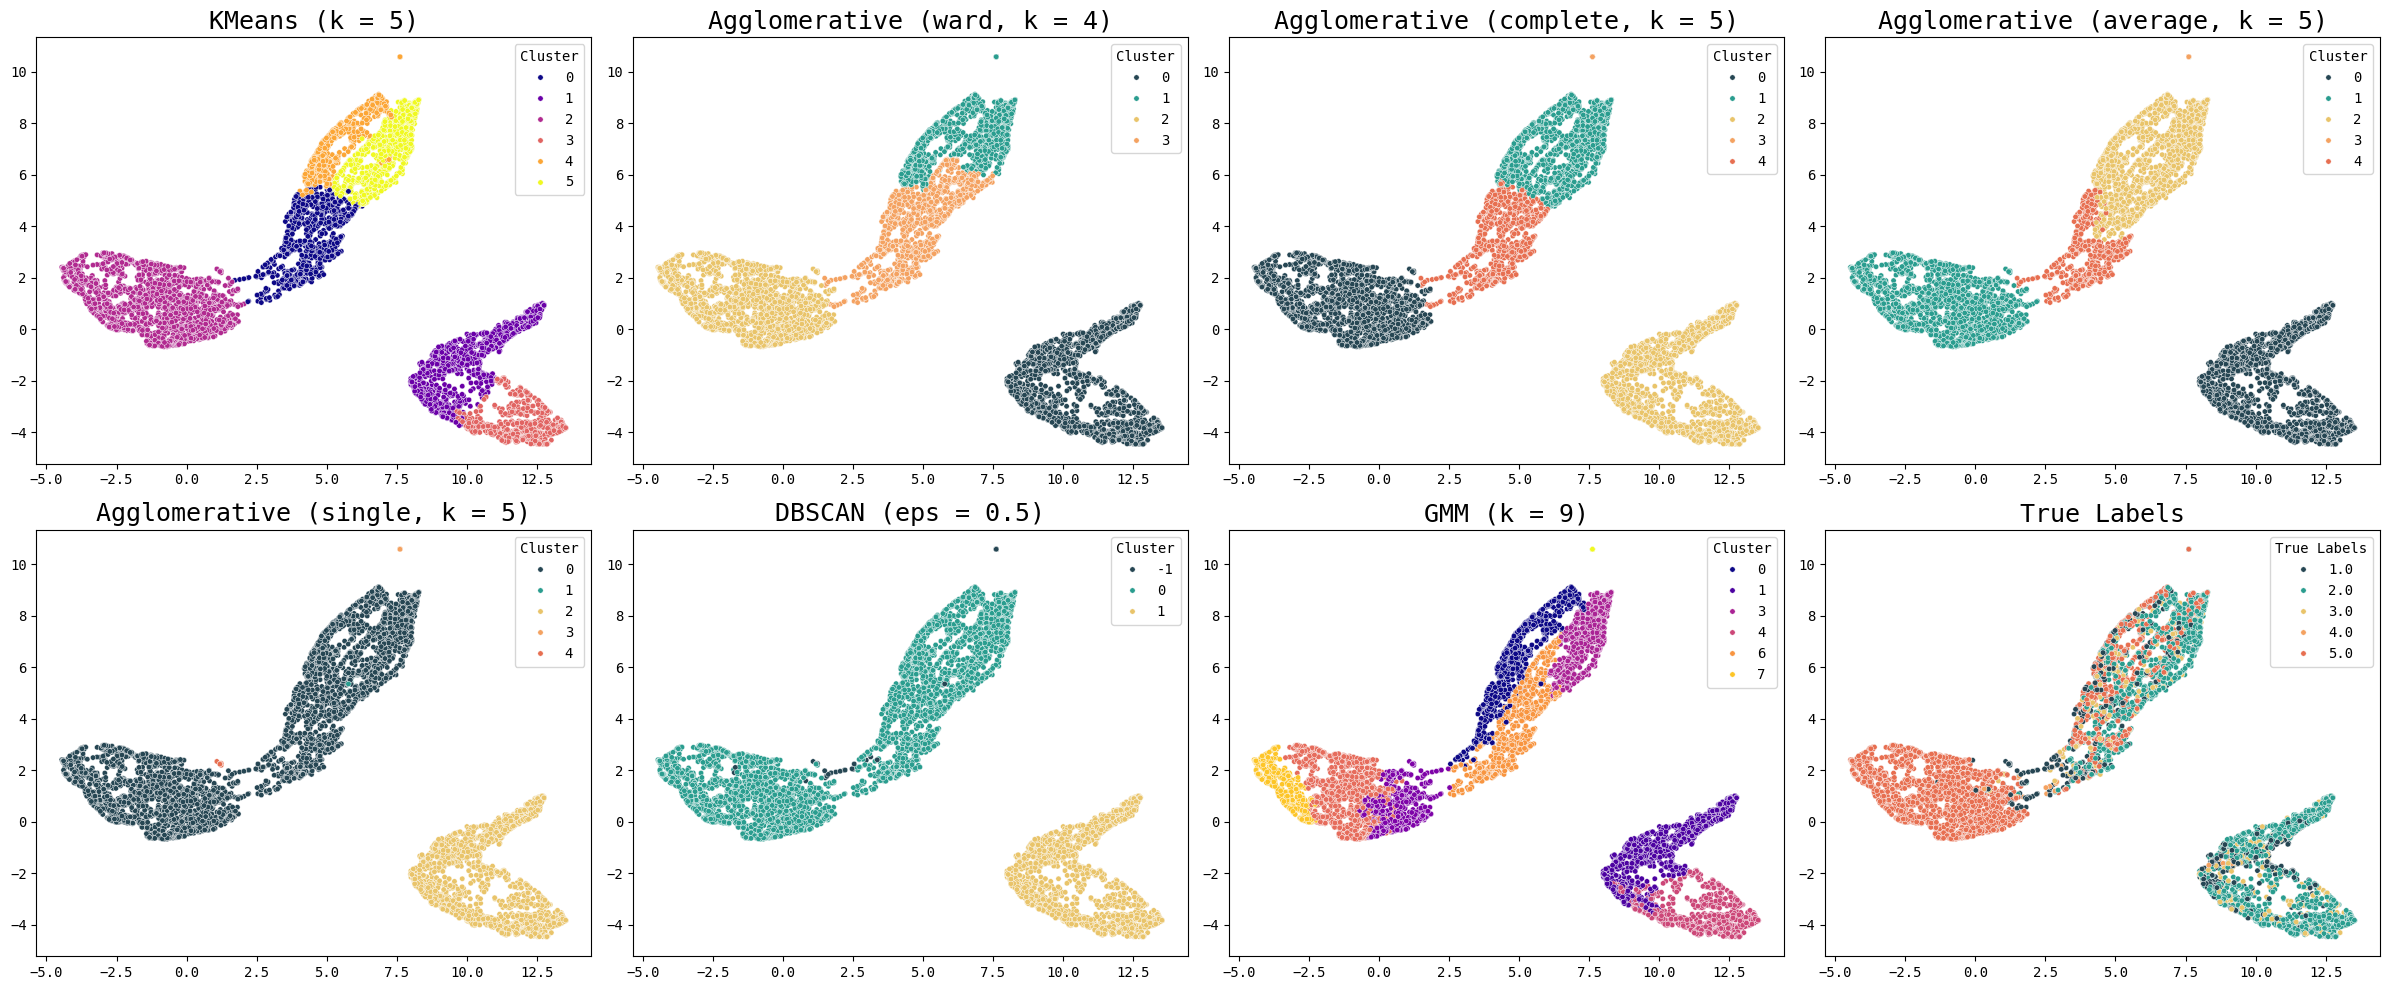

In [63]:
# This time I use 3 PCs because collectively they explain more than 75% of the variance of the data.
reducer = umap.UMAP(n_components = 3, random_state = 19)
X_umap = reducer.fit_transform(X_clustering_scaled)

####################################### Evaluation of K-means ##########################################
print("1) Evaluating KMeans Clustering...")
aris = []
for k in range(2, 20):
    km = KMeans(n_clusters = k, random_state = 19)
    labels = km.fit_predict(X_umap)
    s, a = evaluate_clustering(X_umap, labels, y_clustering)
    aris.append(a)

best_kmeans = np.argmax(aris) + 2
print(f"Best k for Kmeans, by ARI: {best_kmeans}")
kmeans_final = KMeans(n_clusters = best_kmeans, random_state = 19).fit(X_umap)

####################################### Evaluation of agglomerative clustering ##########################
print("2) Evaluating agglomerative Clustering...")
linkages = ['ward', 'complete', 'average', 'single']
agglom_labels = []
agglom_titles = []

for linkage in linkages:
    best_ari = -1
    best_k = None
    best_labels = None
    
    for k in range(2, 20):
        model = AgglomerativeClustering(n_clusters = k, linkage = linkage)
        labels = model.fit_predict(X_umap)
        s, ari = evaluate_clustering(X_umap, labels, y_clustering)
            
        if ari > best_ari:
            best_ari = ari
            best_k = k
            best_labels = labels
    
    agglom_labels.append(best_labels)
    agglom_titles.append(f"Agglomerative ({linkage}, k = {best_k})")
    print(f"Best k for linkage '{linkage}', by ARI: {best_k}")
    
####################################### Evaluation of DBSCAN  ###############################
print("3) Evaluating DBSCAN...")
eps_values = [0.3, 0.5, 0.7, 1.0, 1.3, 1.5, 2.0]
best_score = -1
best_eps = None
best_labels = None

for eps in eps_values:
    db = DBSCAN(eps = eps, min_samples = 15)
    labels = db.fit_predict(X_umap)
    s, ari = evaluate_clustering(X_umap, labels, y_clustering)
    
    if ari > best_score:
        best_score = ari
        best_eps = eps
        best_labels = labels

print(f"Best value for eps, by ARI: {best_eps}")

####################################### Evaluation of GMM  ####################################
print("4) Evaluatig GMM (Expectation Maximization)...")
bic_scores = []
for k in range(2, 10):
    gmm = GaussianMixture(n_components = k, random_state = 19)
    gmm.fit(X_umap)
    bic_scores.append(gmm.bic(X_umap))

best_k_gmm = np.argmin(bic_scores) + 2
gmm_final = GaussianMixture(n_components =  best_k_gmm, random_state = 19).fit(X_umap)
labels_gmm = gmm_final.predict(X_umap)

print(f"Best value for GMM, by BIC: {best_k_gmm}")




################################################## Plots ######################################
plt.figure(figsize=(12, 5))

# ARI scores Kmeans (an example of how the comparison of ARI works)
plt.subplot(1, 2, 1)
plt.plot(range(2, 20), aris, marker='o', color = custom_colors[0])
plt.title("ARI vs K (KMeans)")
plt.xlabel("k")
plt.ylabel("ARI")

# BIC (GMM)
plt.subplot(1, 2, 2)
plt.plot(range(2, 10), bic_scores, marker='o', color = custom_colors[4])
plt.title("BIC Score vs K (GMM)")
plt.xlabel("k")
plt.ylabel("BIC")

plt.tight_layout()
plt.show()


# Finak plots with labels
all_clusterings = [kmeans_final.labels_] + agglom_labels
all_clusterings.append(best_labels)
all_clusterings.append(labels_gmm)

all_titles = [f"KMeans (k = {best_k})"] + agglom_titles
all_titles.append(f"DBSCAN (eps = {best_eps})")
all_titles.append(f"GMM (k = {best_k_gmm})")

plot_all_clusterings(X_umap, all_clusterings, y_clustering, all_titles, cols = 4)


Summary of the results using 3 PCs.

In [64]:
results = []

# KMeans
ari_kmeans = adjusted_rand_score(y_clustering, kmeans_final.labels_)
results.append({
    'Method': 'KMeans',
    'Parameter': f'k = {best_k}',
    'ARI': ari_kmeans
})

# Agglomerative
for linkage, labels in zip(linkages, agglom_labels):
    ari = adjusted_rand_score(y_clustering, labels)
    results.append({
        'Method': 'Agglomerative',
        'Parameter': f'linkage = {linkage}',
        'ARI': ari
    })

# DBSCAN
ari_dbscan = adjusted_rand_score(y_clustering, best_labels)
results.append({
        'Method': 'DBSCAN',
        'Parameter': f'eps = {best_eps}',
        'ARI': ari_dbscan
    })

# GMM
ari_gmm = adjusted_rand_score(y_clustering, labels_gmm)
results.append({
    'Method': 'GMM',
    'Parameter': f'k = {best_k_gmm}',
    'ARI': ari_gmm
})

# Sort dataframe by ARI
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by = 'ARI', ascending = False).reset_index(drop = True)

print("Results, using ARI as comparison")
print(f'\f')
print(df_results)
print(f'\n')
print(f"Best method, by ARI: {df_results.iloc[0]["Method"]}")


Results, using ARI as comparison

          Method           Parameter       ARI
0  Agglomerative  linkage = complete  0.351802
1  Agglomerative   linkage = average  0.348765
2  Agglomerative      linkage = ward  0.347706
3         KMeans               k = 5  0.332813
4         DBSCAN           eps = 0.5  0.222723
5  Agglomerative    linkage = single  0.220010
6            GMM               k = 9  0.170608


Best method, by ARI: Agglomerative


As it is shown in the table, the results improve, although it's still far from the optimal: KMeans is not the best clustering algorithm anymore (although it went from an ARI of around 0.20 to 0.30), but it is outperformed by Agglomerative Clustering with almost all types of linkages. Although 0.35 is still far from an optimal result, the improvement is a good sign.

## 5.5 Clustering - conclusions
Using this approach I obtained 3 defined clusters, but the explanation for it can be found by using, as labels, other variables aside from 'sfdm2'.

C:\Users\flavi\AppData\Local\Temp\ipykernel_20344\1128786106.py:6: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.scatterplot(x = X_umap[:,0], y= X_umap[:,1], hue =  X_clustering['death'], palette=custom_colors, s=10)
C:\Users\flavi\AppData\Local\Temp\ipykernel_20344\1128786106.py:11: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.scatterplot(x = X_umap[:,0], y = X_umap[:,1], hue = X_clustering['hospdead'], palette=custom_colors, s=10)
C:\Users\flavi\AppData\Local\Temp\ipykernel_20344\1128786106.py:23: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.scatterplot(x = X_umap[:,0], y= X_umap[:,1], hue = all_clusterings[-2], palette=custom_colors, s=10)


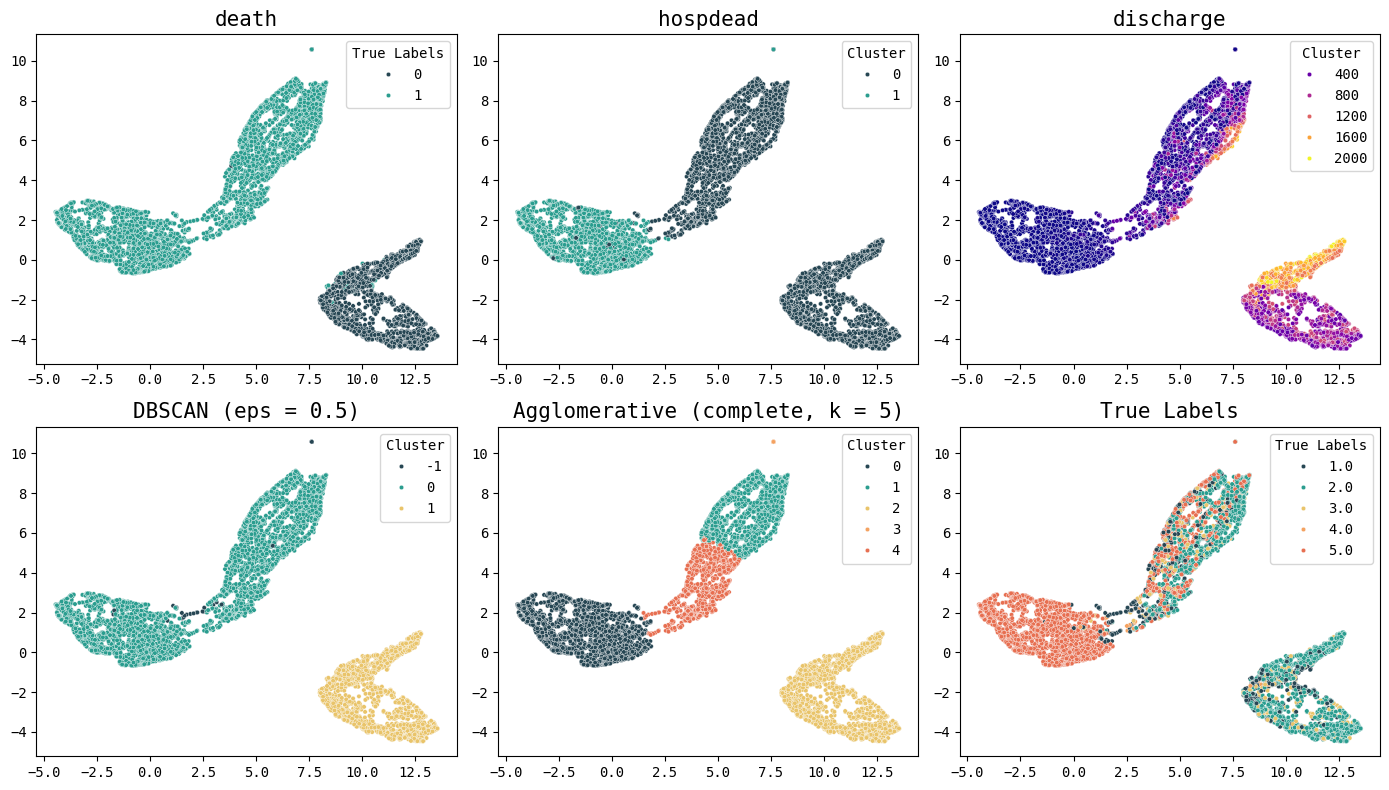

In [65]:
fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(2, 3, figure=fig)


ax1= fig.add_subplot(gs[0,0])
sns.scatterplot(x = X_umap[:,0], y= X_umap[:,1], hue =  X_clustering['death'], palette=custom_colors, s=10)
plt.title("death", fontsize = 15)
plt.legend(title="True Labels", loc='best')

ax2= fig.add_subplot(gs[0,1])
sns.scatterplot(x = X_umap[:,0], y = X_umap[:,1], hue = X_clustering['hospdead'], palette=custom_colors, s=10)
plt.title("hospdead", fontsize = 15)
plt.legend(title="Cluster", loc='best')

ax3 = fig.add_subplot(gs[0,2])
sns.scatterplot(x = X_umap[:,0], y = X_umap[:,1], hue = X_clustering['d.time'], palette= "plasma", s=10)
plt.title("discharge", fontsize = 15)
plt.legend(title="Cluster", loc='best')



ax4= fig.add_subplot(gs[1,0])
sns.scatterplot(x = X_umap[:,0], y= X_umap[:,1], hue = all_clusterings[-2], palette=custom_colors, s=10)
plt.title(all_titles[-2], fontsize = 15)
plt.legend(title ="Cluster", loc='best')

ax5= fig.add_subplot(gs[1,1])
sns.scatterplot(x = X_umap[:,0], y= X_umap[:,1], hue = all_clusterings[2], palette=custom_colors, s=10)
plt.title(all_titles[2], fontsize = 15)
plt.legend(title= "Cluster", loc='best')

ax6= fig.add_subplot(gs[1,2])
sns.scatterplot(x = X_umap[:,0], y= X_umap[:,1], hue = y_clustering, palette=custom_colors, s = 10)
plt.title("True Labels", fontsize = 15)
plt.legend(title="True Labels", loc='best')

plt.tight_layout()
plt.show()

The clustering avtually appears to reflect the variables about the death of people.
The agglomerative clustering (complete linkage) with the "best" Adjusted Rand Index can catch three main clusters:
- on the left, people that died, and died at the hospital;
- on the center/top right, people that died but not at the hospital;
- on the bottom right, people that didn't die.

Sfdm2 is a subjective scale: although it can be transformed in numeric values (an higher value means an higher level of disability) it's still an information collected after either a visual examination or an interview from the patient themself or their relatives, in the first 3 days of entering the study.

The best clustering method can almost catch very high values (5) on the left, which corresponds to people that died at the hospital. This doesn't surprise us in the slightest: as we've seen, the people that died in the hospital, did so in a very short time and the reason for a sfdm2 value of 5 is to be dead in the first 2 months of the study. Low values (1-2, maximum 3 in some cases) for people that didn't die at all are featured in the bottom right cluster.  

The situation with people that died outside of the hospital it's quite vague, instead: that cluster (center/top right) contains all of the range of values, reflecting the heterogeneous group of people that belong there. Those who died right after being discharged (before the 1 year mark) and those who did after almost 3 years are all grouped there, and this can mean that people that, when entering the study had a very low sfdm2 score could die years later with a theoretically higher score, although we wouldn't know as it doesn't get updated. This clustering method further divides the values in another 2 clusters (since it chooses K = 5), but when looking at the true labels the suddivision is not that evident.

In synthesis, it's impossible to distinguish the 5 sfdm2 clusters with completely **unsupervised learning** using all variables (with the only restriction being % of missing data), which can at maximum distinguish two groups using KMeans: low values (1-2) versus medium and high values (3-4-5). Using the original 1 to 5 scale of 'sfdm2' for evaluation, though, this clustering method obtains an ARI score of around 0.20 and so do all the other clustering methods.

With a pipeline constructed exactly with the objective of focusing on numerical variables that are correlated to 'sfdm2' at least a little (r > |0.10|), the clustering can distinguish three clusters in the agglomerative (complete) case: very high values (5), low values (1 to 3) and intermediate ones (3-4), but this seems to best represent "death" and "hospdead" variables, and not 'sfdm2' itself. Although the clustering was performed in an unsupervised fashion (sfdm2 was not included in the input features), the variable selection process used the 'sfdm2' label so this approach could be better described as an hybrid learning approach. The use of these variables, though, could be used to decrease noise for future problems where 'sfdm2' is not provided, in a true unsupervised learning setting.

I still recommend, when designing a study, to substitute sfdm2 value with a numerical value that could be more easily measured and not left to the judgement of the patient or their relatives, as it can lead to unwanted bias.